<a href="https://colab.research.google.com/github/austinbennysmith/CMIP6/blob/main/NAO_historical_Normalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **This notebook calculates an NAO index for historical simulations from CMIP6**

Commenting is minimal here since the code is pretty similar to other programs in this folder.

There seems to be qualitative agreement between the modelled historical NAO index plotted here and Figure 1 of the following article: https://www.pnas.org/content/98/23/12876

In [ ]:
!pip install fsspec
!pip install netCDF4
!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;
!pip install shapely --no-binary shapely;
!pip install eofs
! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
import pandas as pd
import xarray as xr
import zarr
import fsspec
import gcsfs
from eofs.xarray import Eof
from nc_time_axis import NetCDFTimeConverter, CalendarDateTime
import cftime
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv') 
df.head()

activity_id institution_id  ... dcpp_init_year   version
0  HighResMIP           CMCC  ...            NaN  20170706
1  HighResMIP           CMCC  ...            NaN  20170706
2  HighResMIP           CMCC  ...            NaN  20170706
3  HighResMIP           CMCC  ...            NaN  20170706
4  HighResMIP           CMCC  ...            NaN  20170706

[5 rows x 11 columns]

In [ ]:
# The following code just prints the number of ensemble members for each model for reference
ssp = df.query("variable_id == 'psl' & experiment_id == 'historical' & table_id == 'Amon'")
unique_sources = []
for i in ssp['source_id']:
  if i not in unique_sources:
    unique_sources.append(i)
print(unique_sources)

for i in unique_sources:
  x = ssp.query("source_id =="+"'"+i+"'")
  print(str(len(x))+': '+i)

['GFDL-CM4', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'GISS-E2-1-G', 'CNRM-CM6-1', 'BCC-CSM2-MR', 'CNRM-ESM2-1', 'MIROC6', 'BCC-ESM1', 'AWI-CM-1-1-MR', 'MRI-ESM2-0', 'CESM2-WACCM', 'CESM2', 'SAM0-UNICON', 'GISS-E2-1-H', 'UKESM1-0-LL', 'CanESM5-CanOE', 'CanESM5', 'INM-CM4-8', 'INM-CM5-0', 'HadGEM3-GC31-LL', 'MPI-ESM-1-2-HAM', 'NESM3', 'CAMS-CSM1-0', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'E3SM-1-0', 'MCM-UA-1-0', 'GISS-E2-1-G-CC', 'NorESM2-LM', 'FGOALS-g3', 'MIROC-ES2L', 'KACE-1-0-G', 'NorCPM1', 'FGOALS-f3-L', 'CNRM-CM6-1-HR', 'KIOST-ESM', 'ACCESS-CM2', 'NorESM2-MM', 'FIO-ESM-2-0', 'ACCESS-ESM1-5', 'CESM2-FV2', 'CESM2-WACCM-FV2', 'HadGEM3-GC31-MM', 'E3SM-1-1', 'IITM-ESM', 'EC-Earth3-Veg', 'EC-Earth3', 'AWI-ESM-1-1-LR', 'EC-Earth3-Veg-LR', 'CAS-ESM2-0', 'CIESM', 'CMCC-CM2-SR5', 'E3SM-1-1-ECA', 'TaiESM1', 'EC-Earth3-AerChem', 'CMCC-CM2-HR4', 'CMCC-ESM2']
1: GFDL-CM4
3: GFDL-ESM4
32: IPSL-CM6A-LR
46: GISS-E2-1-G
30: CNRM-CM6-1
3: BCC-CSM2-MR
10: CNRM-ESM2-1
50: MIROC6
3: BCC-ESM1
5: AWI-CM-1-1-MR
6: MRI-ES

In [ ]:
from datetime import date, timedelta
import netCDF4 as nc
psl_ssp585 = df.query("variable_id == 'psl' & experiment_id == 'historical' & institution_id == 'NCAR' & source_id == 'CESM2' & table_id == 'Amon'")
# psl_hist = df.query("variable_id == 'psl' & experiment_id == 'historical'")
for i in range(len(psl_ssp585)):
  print(i)
# psl_hist

0
1
2
3
4
5
6
7
8
9
10


Getting the right lats/lons/times:

In [ ]:
# Accessing the file, getting it to just the lats and lons I want:
zstore = psl_ssp585.zstore.values[0]
mapper = fsspec.get_mapper(zstore)
ds = xr.open_zarr(mapper, consolidated=True, decode_times=True) # Make decode_times=True to convert dates to datetime objects?? The problem is, Colab doesn't seem to like my installation of nc-time-axis. I could try a Jupyter Binder, or keep Googling to try to solve this.
psl = ds.psl.sel(lat=slice(20,80))
psl = psl.where((ds.lon >= 270) | (ds.lon <= 40), drop=True)
lat = ds.lat.sel(lat=slice(20,80))
lon = ds.lon.where((ds.lon >= 270) | (ds.lon <= 40), drop=True) # Not sure exactly what drop means, but I think it doesn't matter


# Useful stackexchange post: https://stackoverflow.com/questions/40272222/select-xarray-pandas-index-based-on-specific-months
def is_djf(month):
  return (month>=12) | ((month>=1) & (month<=2))
def is_mam(month):
  return (month>=3) & (month<=5)
def is_jja(month):
  return (month>=6) & (month<=8)
def is_son(month):
  return (month>=9) & (month<=11)
psl_djf = psl.sel(time=is_djf(psl['time.month']))
psl_mam = psl.sel(time=is_mam(psl['time.month']))
psl_jja = psl.sel(time=is_jja(psl['time.month']))
psl_son = psl.sel(time=is_son(psl['time.month']))


psl_allseasons = {
    'DJF': psl_djf,
    'MAM': psl_mam,
    'JJA': psl_jja,
    'SON': psl_son
}
# # Splitting it up by decade:
# decades = np.arange(1850, 2030, 10)
# decade_list = [] # I'll use decade_list for graphing.
# for i in range(len(decades)):
#   if i<(len(decades)-1):
#     decade_list.append(str(decades[i])+'-'+str(decades[i+1]))

# def in_decade(minyear, maxyear, year):
#   return (year>=minyear) & (year<maxyear)
# psl_FINAL = {
#     'DJF': [],
#     'MAM': [],
#     'JJA': [],
#     'SON': []
# }
# for j in psl_allseasons.keys():
#   for i in range(1, len(decades)):
#     psl_FINAL[j].append(psl_allseasons[j].sel(time=in_decade(decades[i-1], decades[i], psl_allseasons[j]['time.year'])))

# # I need to weight the data by the square root of the cosine of latitude. Right now I think it's working
# psl_WEIGHTED = {
#     'DJF': [],
#     'MAM': [],
#     'JJA': [],
#     'SON': []
# }
# weights = np.sqrt(np.cos(np.radians(psl_FINAL['JJA'][0].lat))) # Latitudes are the same for all of the sub-datasets, so I can define the weights according to latitude based on a randomly chosen sub-dataset outside of the for loop to save time
# for season in psl_FINAL.keys():
#   for i in range(len(psl_FINAL[season])): # Need to do this for each decade within the seasonal dictionary entries
#     tlength = len(psl_FINAL[season][i].time) # Need to have the correct time length in order to make the arrays below.
#     psl_weighted = np.ones((tlength, 64, 105)) # This will be filled up with the weighted latitudes.
#     loaded_psl = psl_FINAL[season][i].values #Loading the data before the for loop drastically speeds up the program
#     for j in range(64):
#       psl_weighted[:, j, :] = loaded_psl[:, j, :]*float(weights[j])
#     psl_WEIGHTED[season].append(psl_weighted)

# Udict = {
#     'DJF': [],
#     'MAM': [],
#     'JJA': [],
#     'SON': []
# }
# sdict = {
#     'DJF': [],
#     'MAM': [],
#     'JJA': [],
#     'SON': []
# }
# VTdict = {
#     'DJF': [],
#     'MAM': [],
#     'JJA': [],
#     'SON': []
# }
# Sigmadict = {
#     'DJF': [],
#     'MAM': [],
#     'JJA': [],
#     'SON': []
# }
# estimatedict = {
#     'DJF': [],
#     'MAM': [],
#     'JJA': [],
#     'SON': []
# }

# for key in psl_FINAL.keys():
#   for i in range(9):
#     print(i)
#     tlength = len(psl_FINAL[key][i].time) # The psl_WEIGHTED dictionary does not contain DataArray objects, so I can't just get the time from that.
#     psl2d = np.reshape(psl_WEIGHTED[key][i], (tlength, 6720)) # This is the only line in the for loop I changed when adding in the weighting
#     psl2d = np.matrix.transpose(psl2d)
#     Unow, snow, VTnow = LA.svd(psl2d, full_matrices=False)
#     Sigmanow = np.diag(snow)
#     estimatenow = Unow[:, :1] @ Sigmanow[0:1, :1] @ VTnow[:1, :]
#     estimatenow = np.matrix.transpose(estimatenow) #Doing this so that I can later reshape the approximation matrix to have dimensionality (time, lat, lon), for consistency since this is how the climate NetCDF files are typically structured.
#     Udict[key].append(Unow)
#     sdict[key].append(snow)
#     VTdict[key].append(VTnow)
#     estimatedict[key].append(estimatenow)

Singular Value Decomposition:

In [ ]:
century_trends = {
    'DJF': {},
    'JJA': {},
    'MAM': {},
    'SON': {}
}
for key in psl_allseasons.keys():
  print(key)
  tlength = len(psl_allseasons[key].time) # The psl_WEIGHTED dictionary does not contain DataArray objects, so I can't just get the time from that.
  psl2d = np.reshape(psl_allseasons[key].values, (tlength, 6720)) # This is the only line in the for loop I changed when adding in the weighting
  psl2d = np.matrix.transpose(psl2d)
  Unow, snow, VTnow = LA.svd(psl2d, full_matrices=False)
  century_trends[key]['U'] = Unow
  century_trends[key]['s'] = snow
  century_trends[key]['VT'] = VTnow

DJF
MAM
JJA
SON


Getting the anomalies & normalized anomalies of the PCs:

In [ ]:
eigenpatterns = {}
SEASONS = ['DJF', 'MAM', 'JJA', 'SON']
# Moving average code from https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
for singVal in range(2): # the range here decides for how many singular values the patterns are normalized and smoothed
  eigenpatterns['singVal '+str(singVal)]={
      'anomalies': {},
      'normalized': {},
      'smoothed': {}
  }
  for season in SEASONS:
    eigenpatterns['singVal '+str(singVal)]['anomalies'][season] = century_trends[season]['VT'][singVal]-np.mean(century_trends[season]['VT'][singVal])
    eigenpatterns['singVal '+str(singVal)]['normalized'][season] = eigenpatterns['singVal '+str(singVal)]['anomalies'][season]/np.std(century_trends[season]['VT'][singVal])
    nao_smoothed = moving_average(eigenpatterns['singVal '+str(singVal)]['anomalies'][season], 30) # Doing the moving average for 30 points because each season is 3 months per year - so this is a 10 year running mean
    eigenpatterns['singVal '+str(singVal)]['smoothed'][season] = nao_smoothed/np.std(nao_smoothed)

Plotting the NAOI time series:

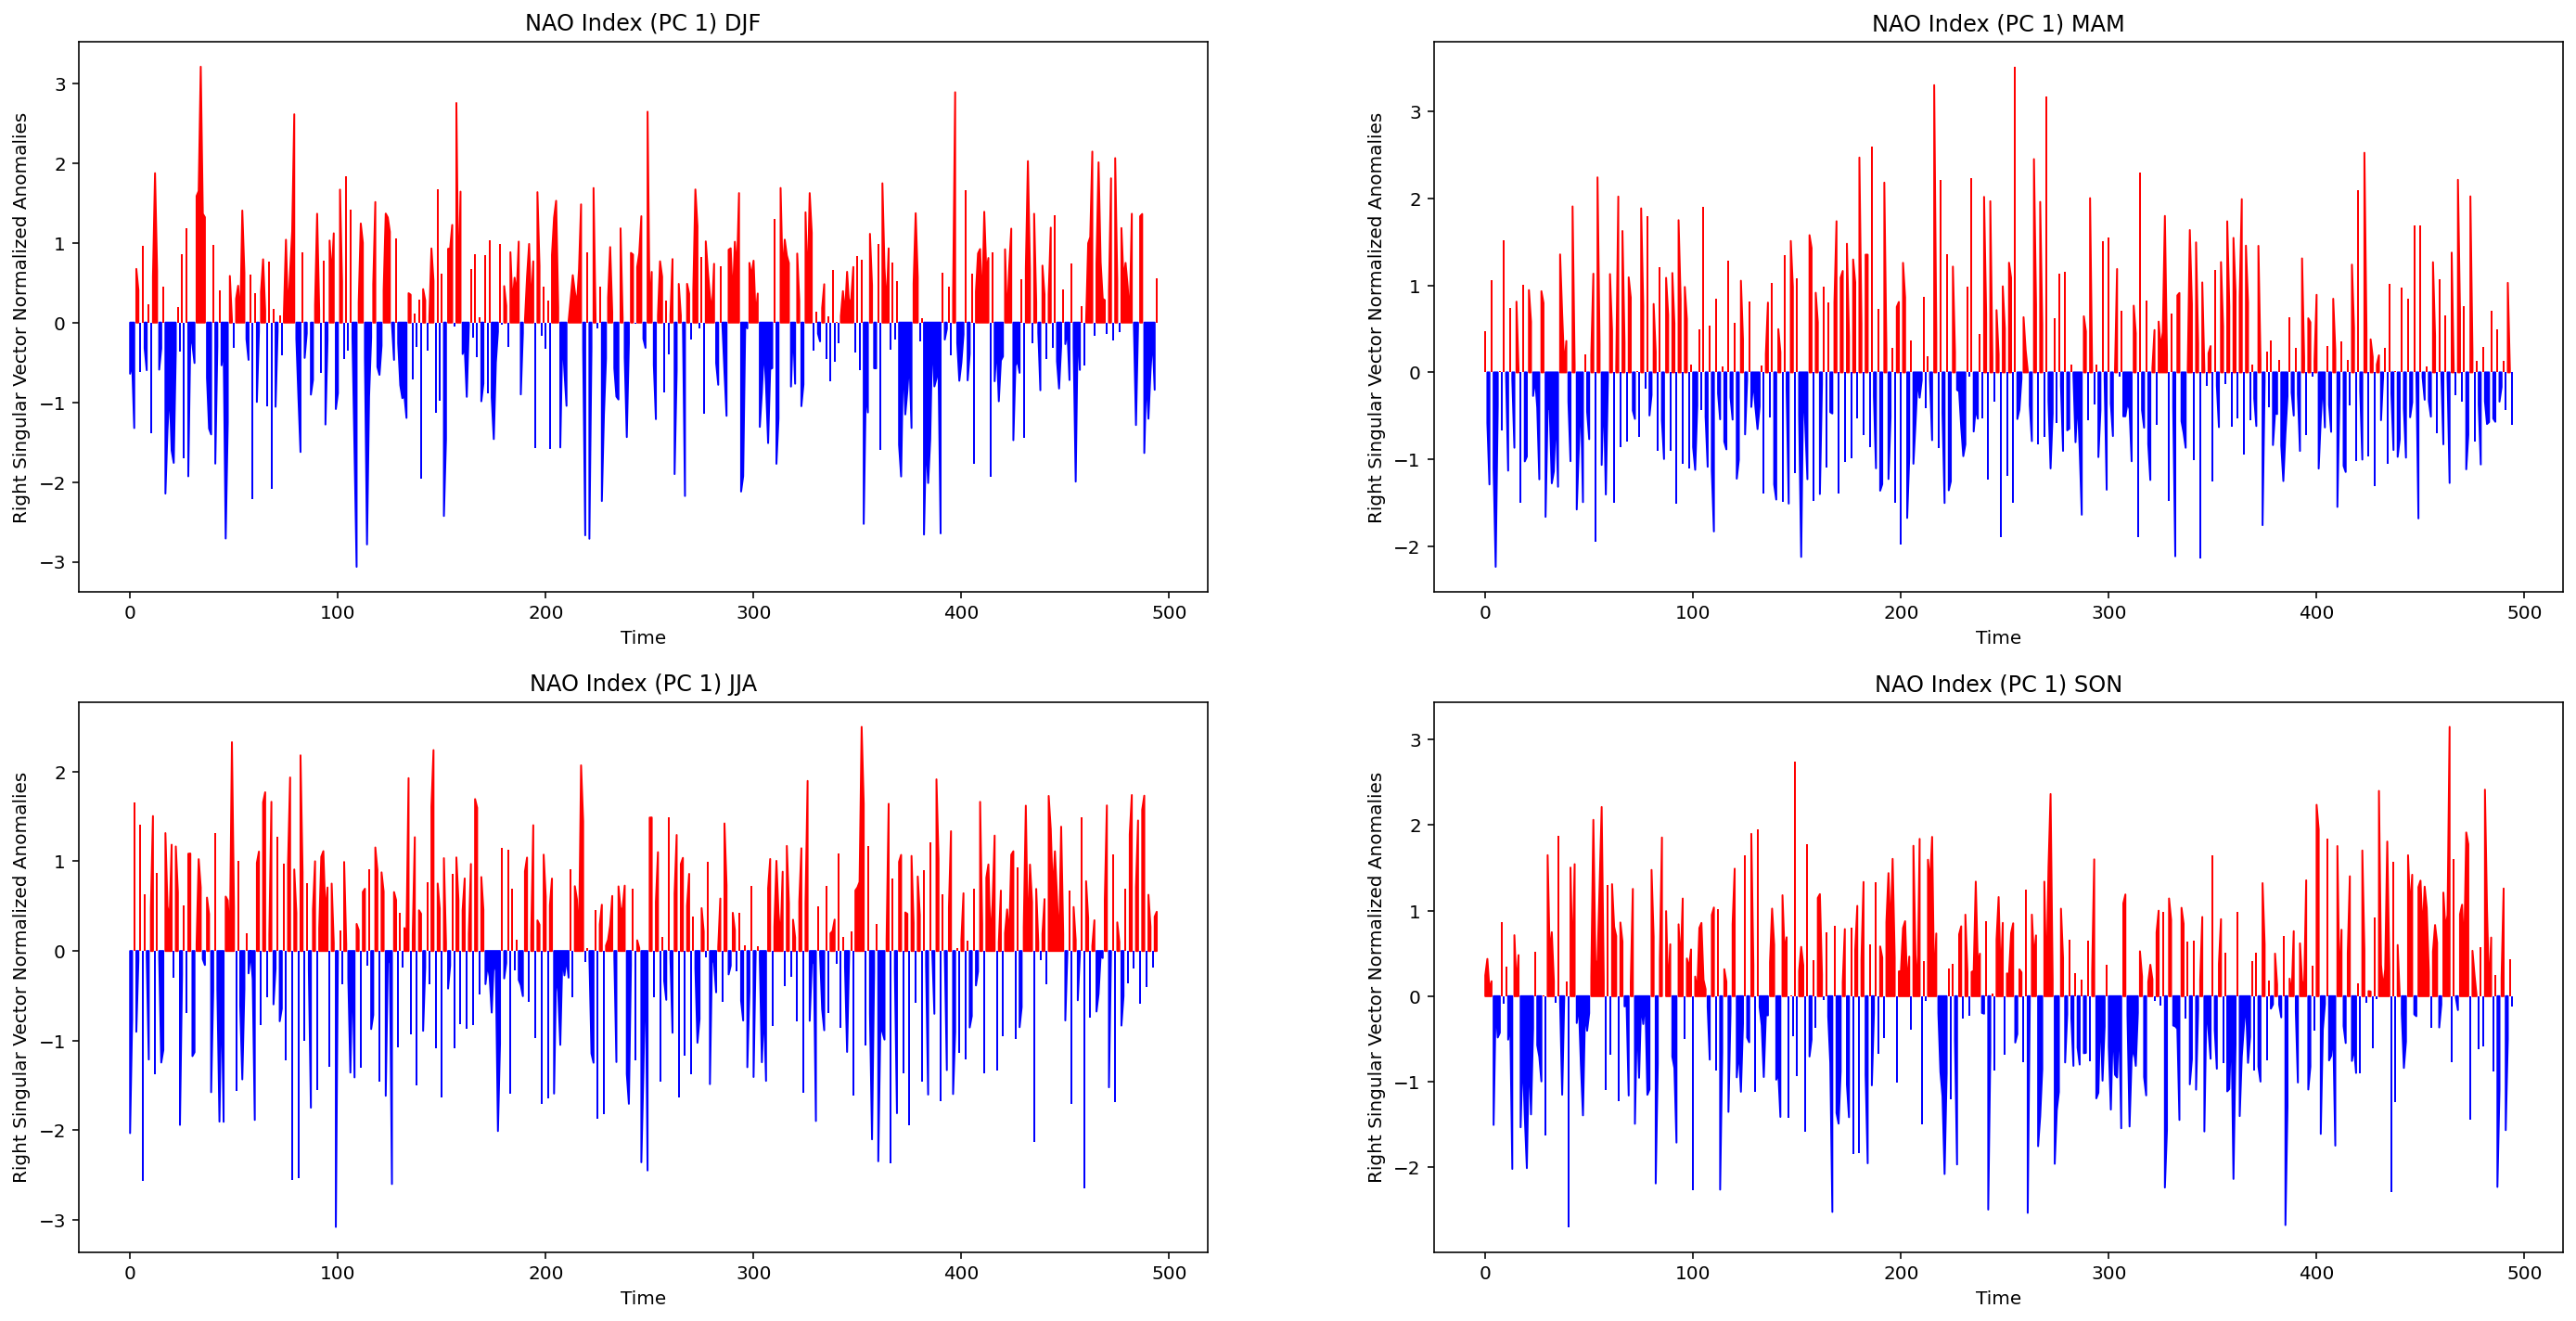

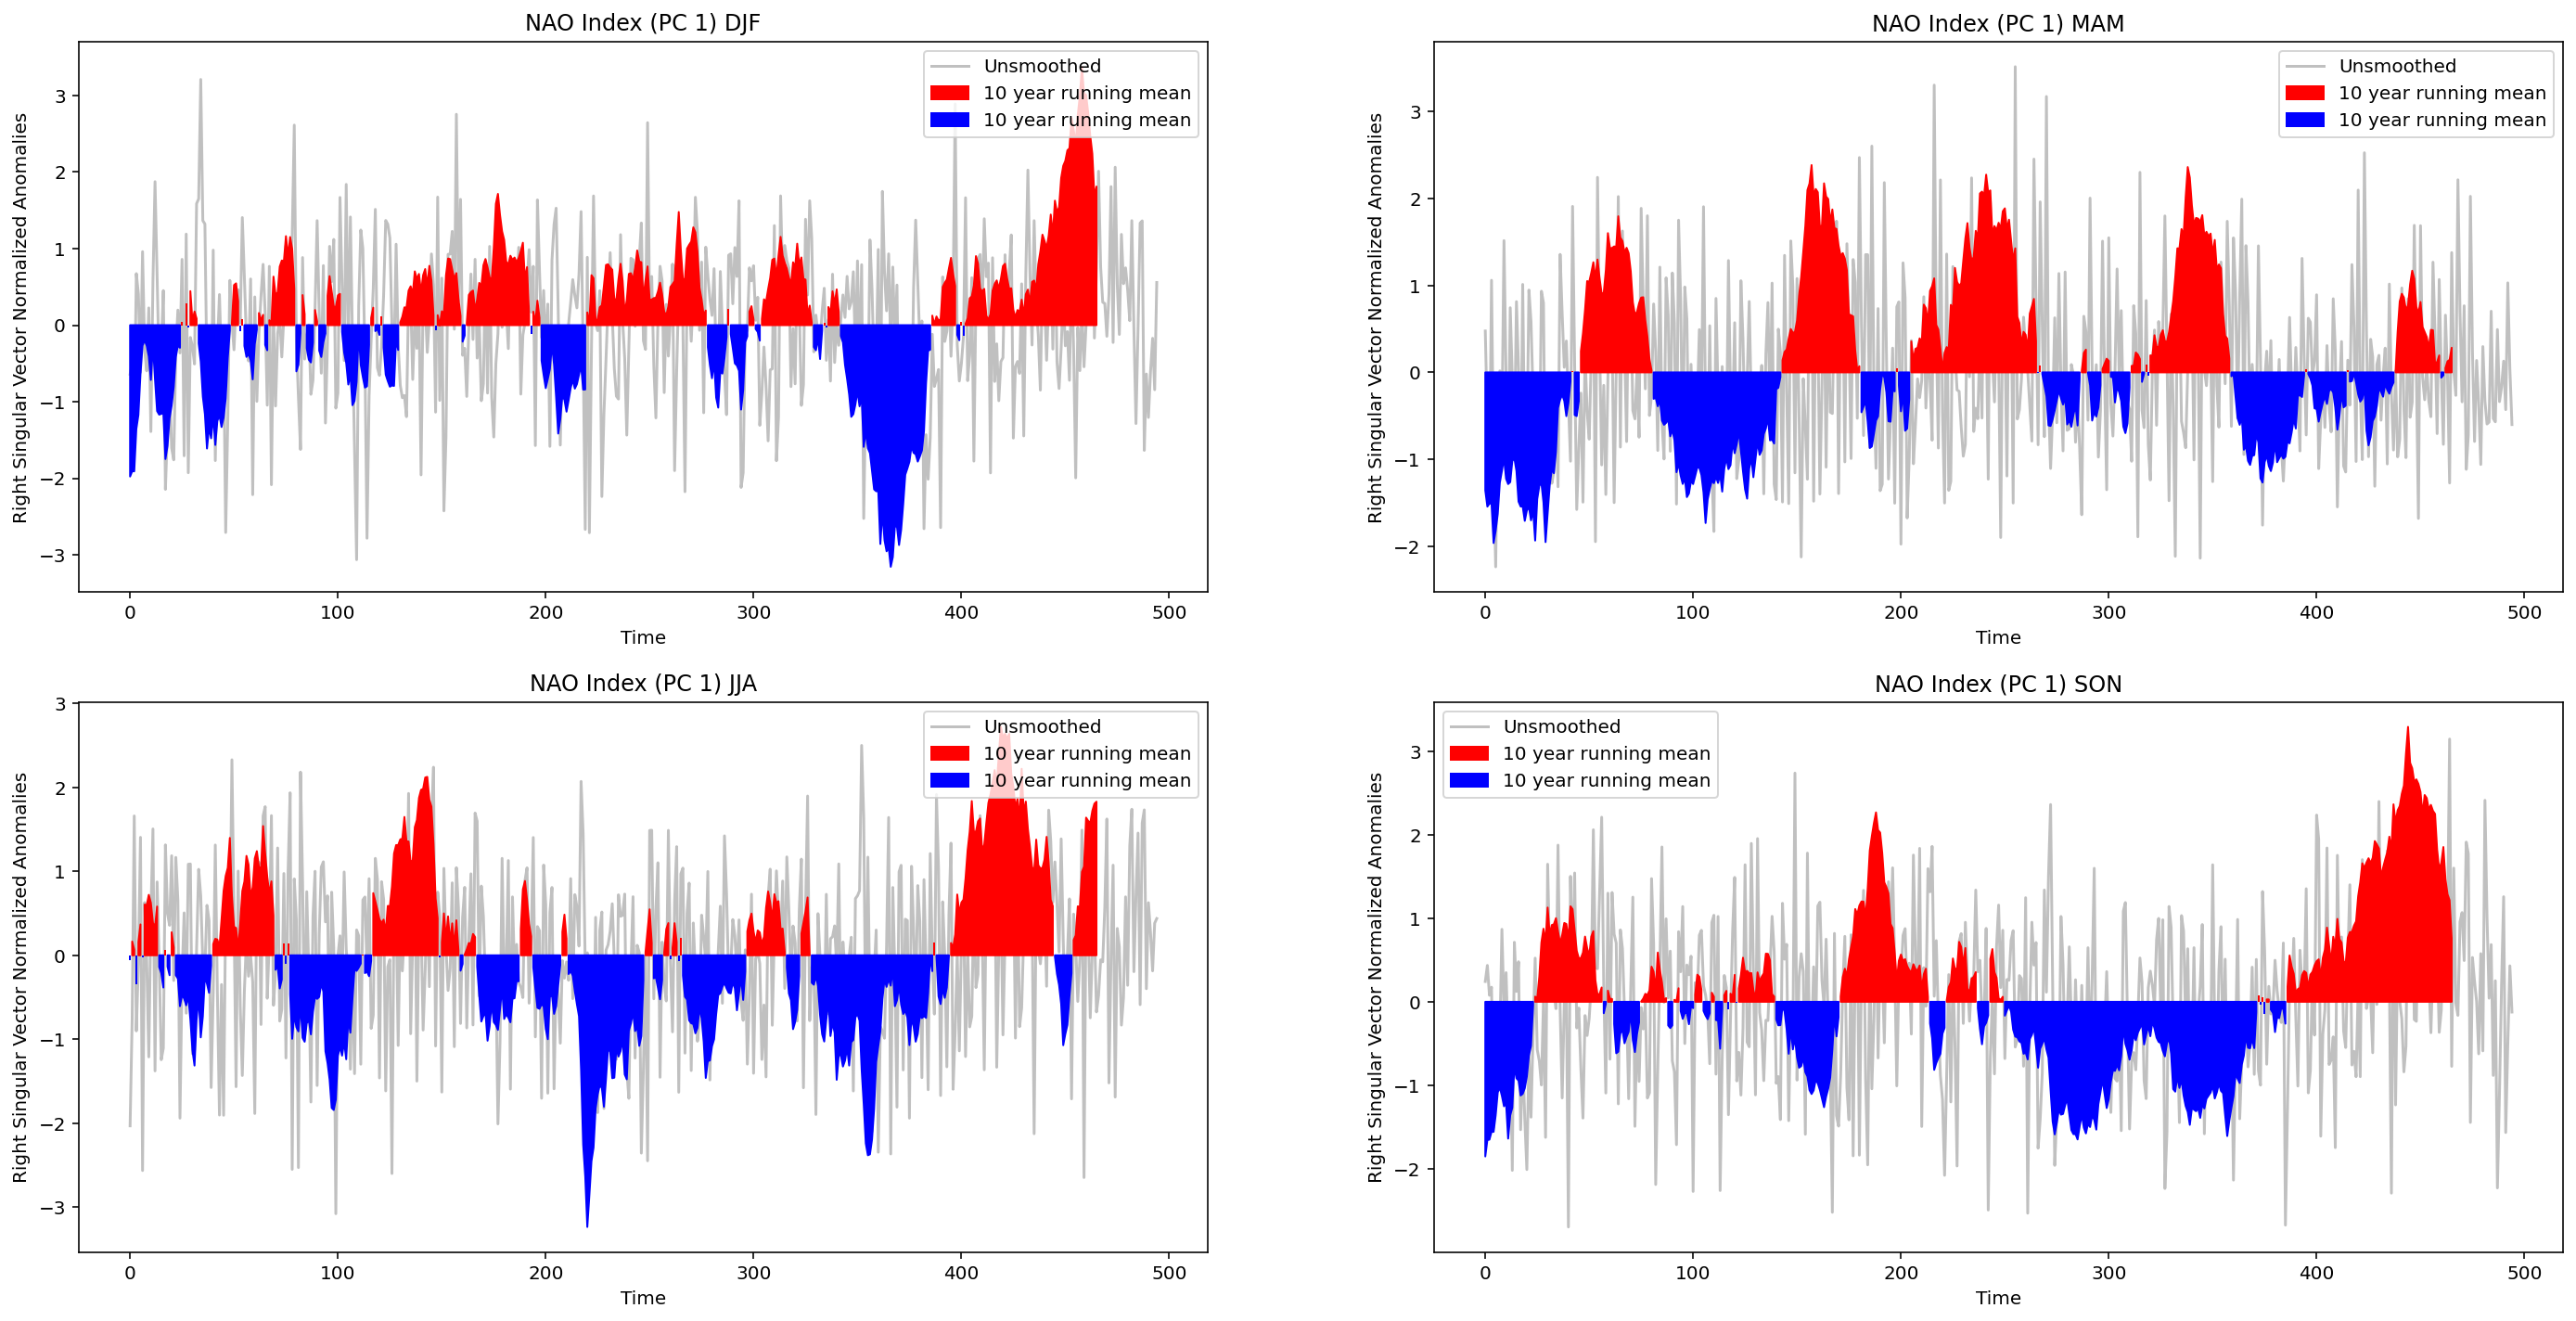

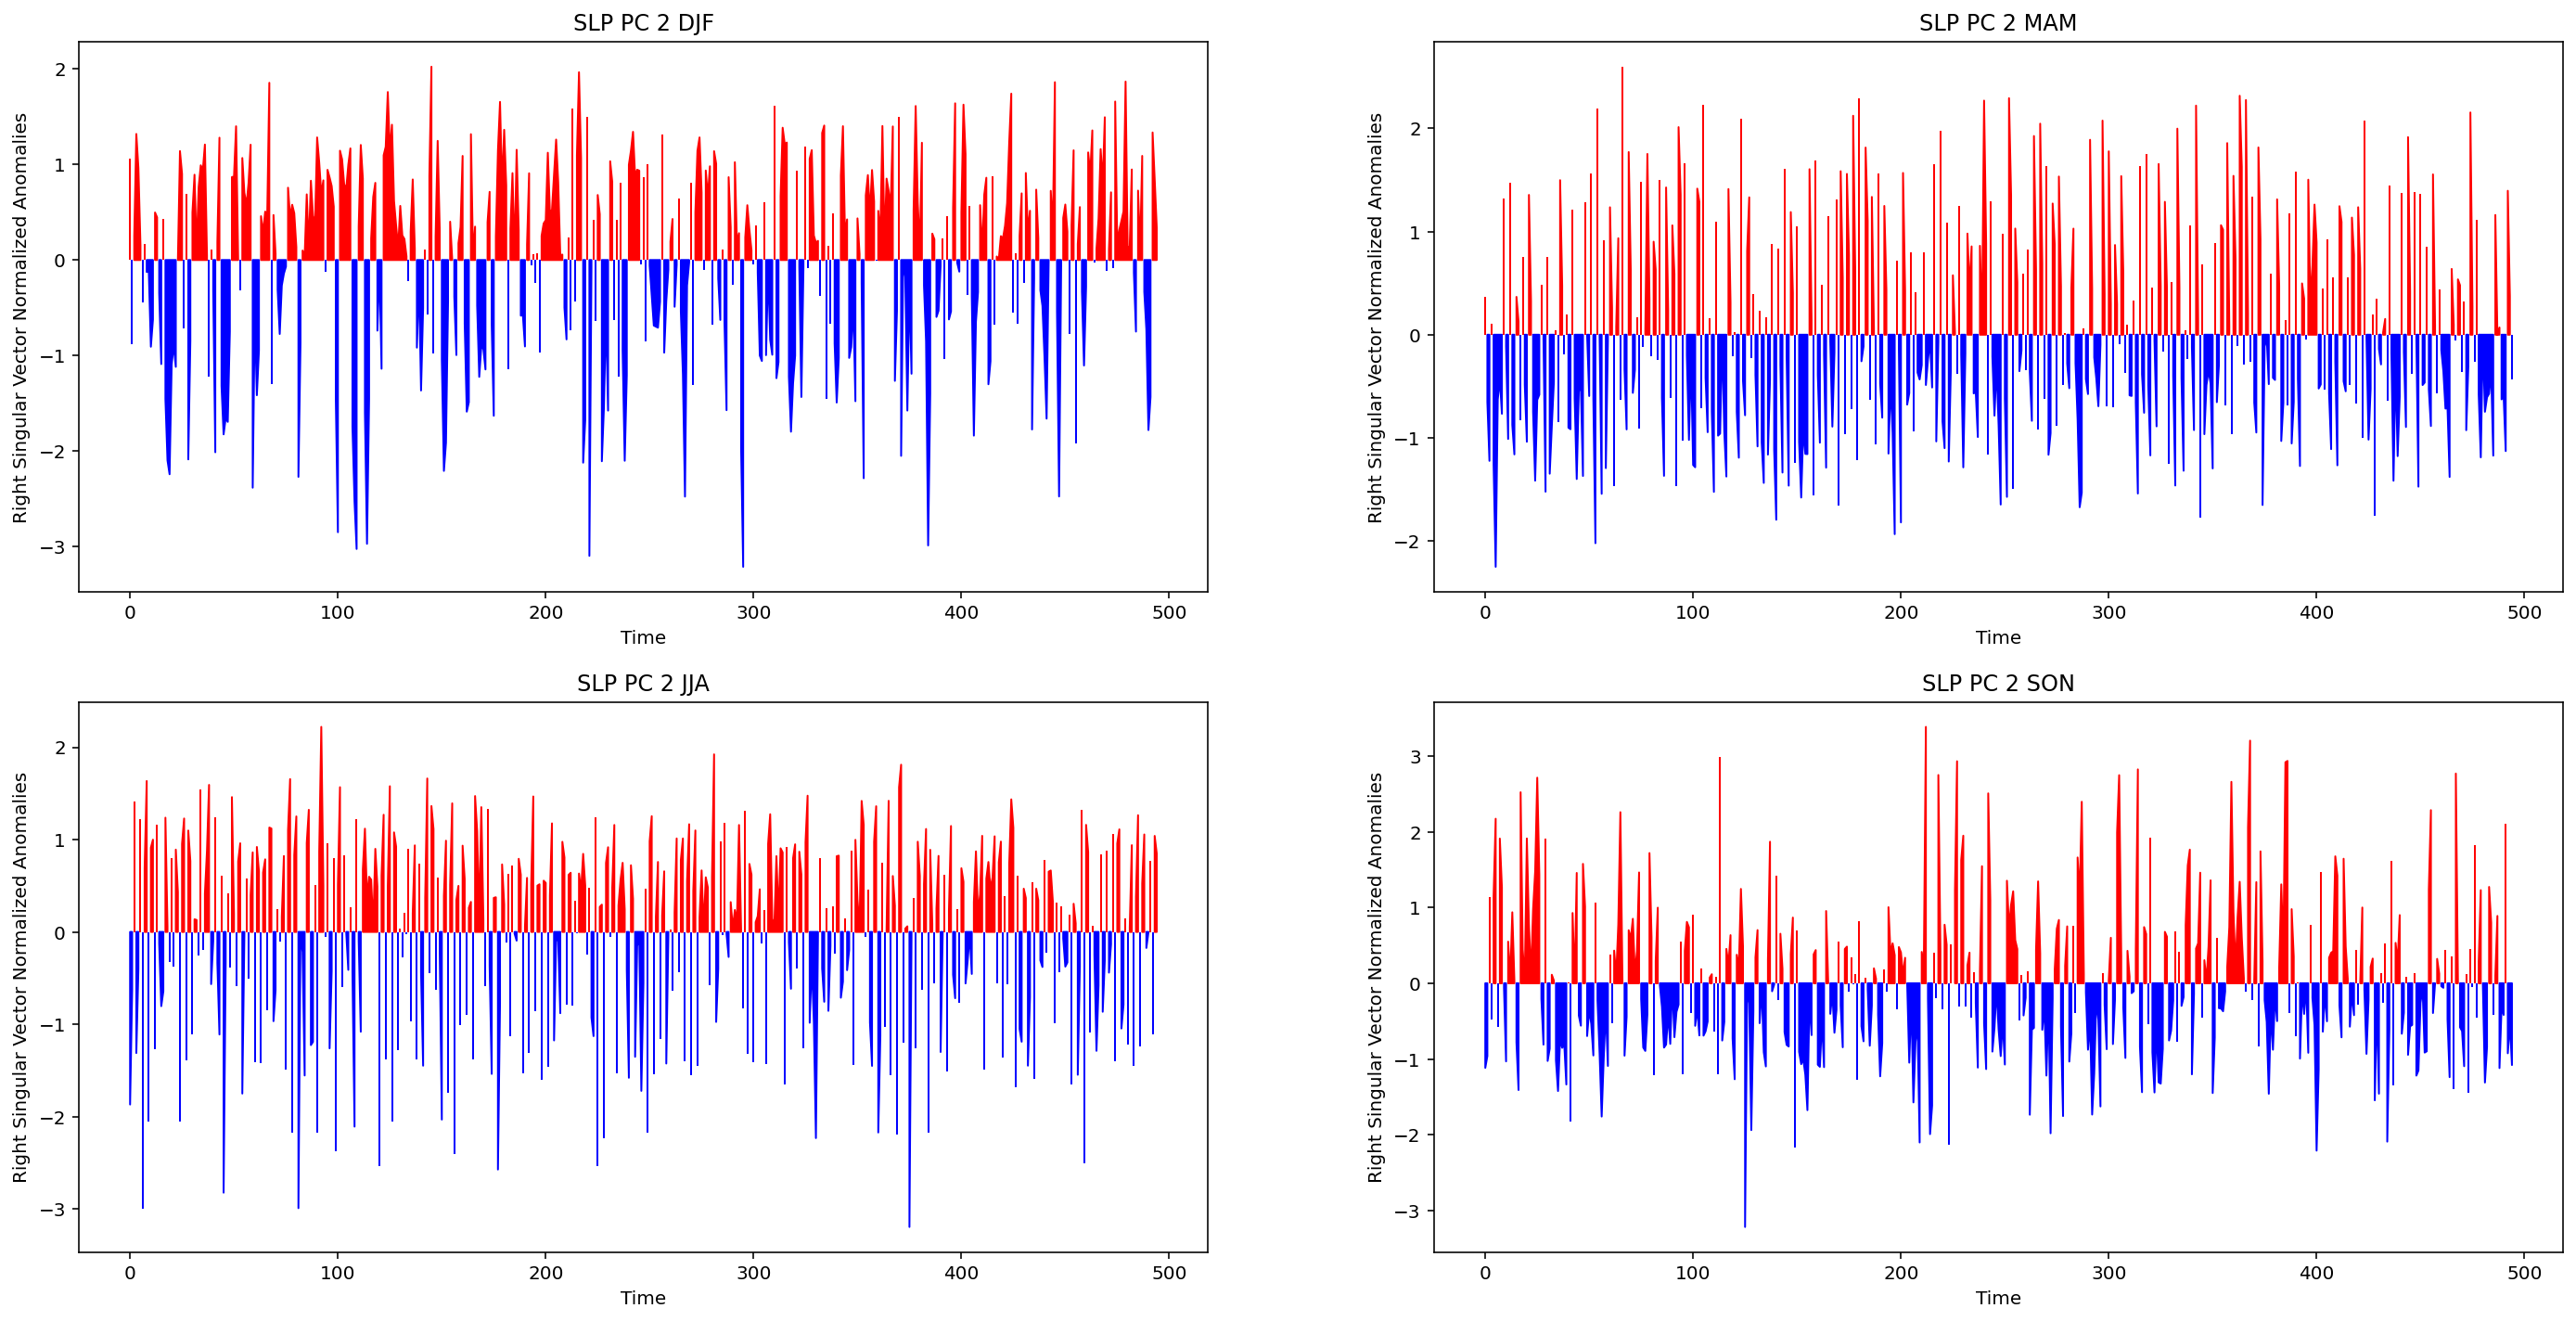

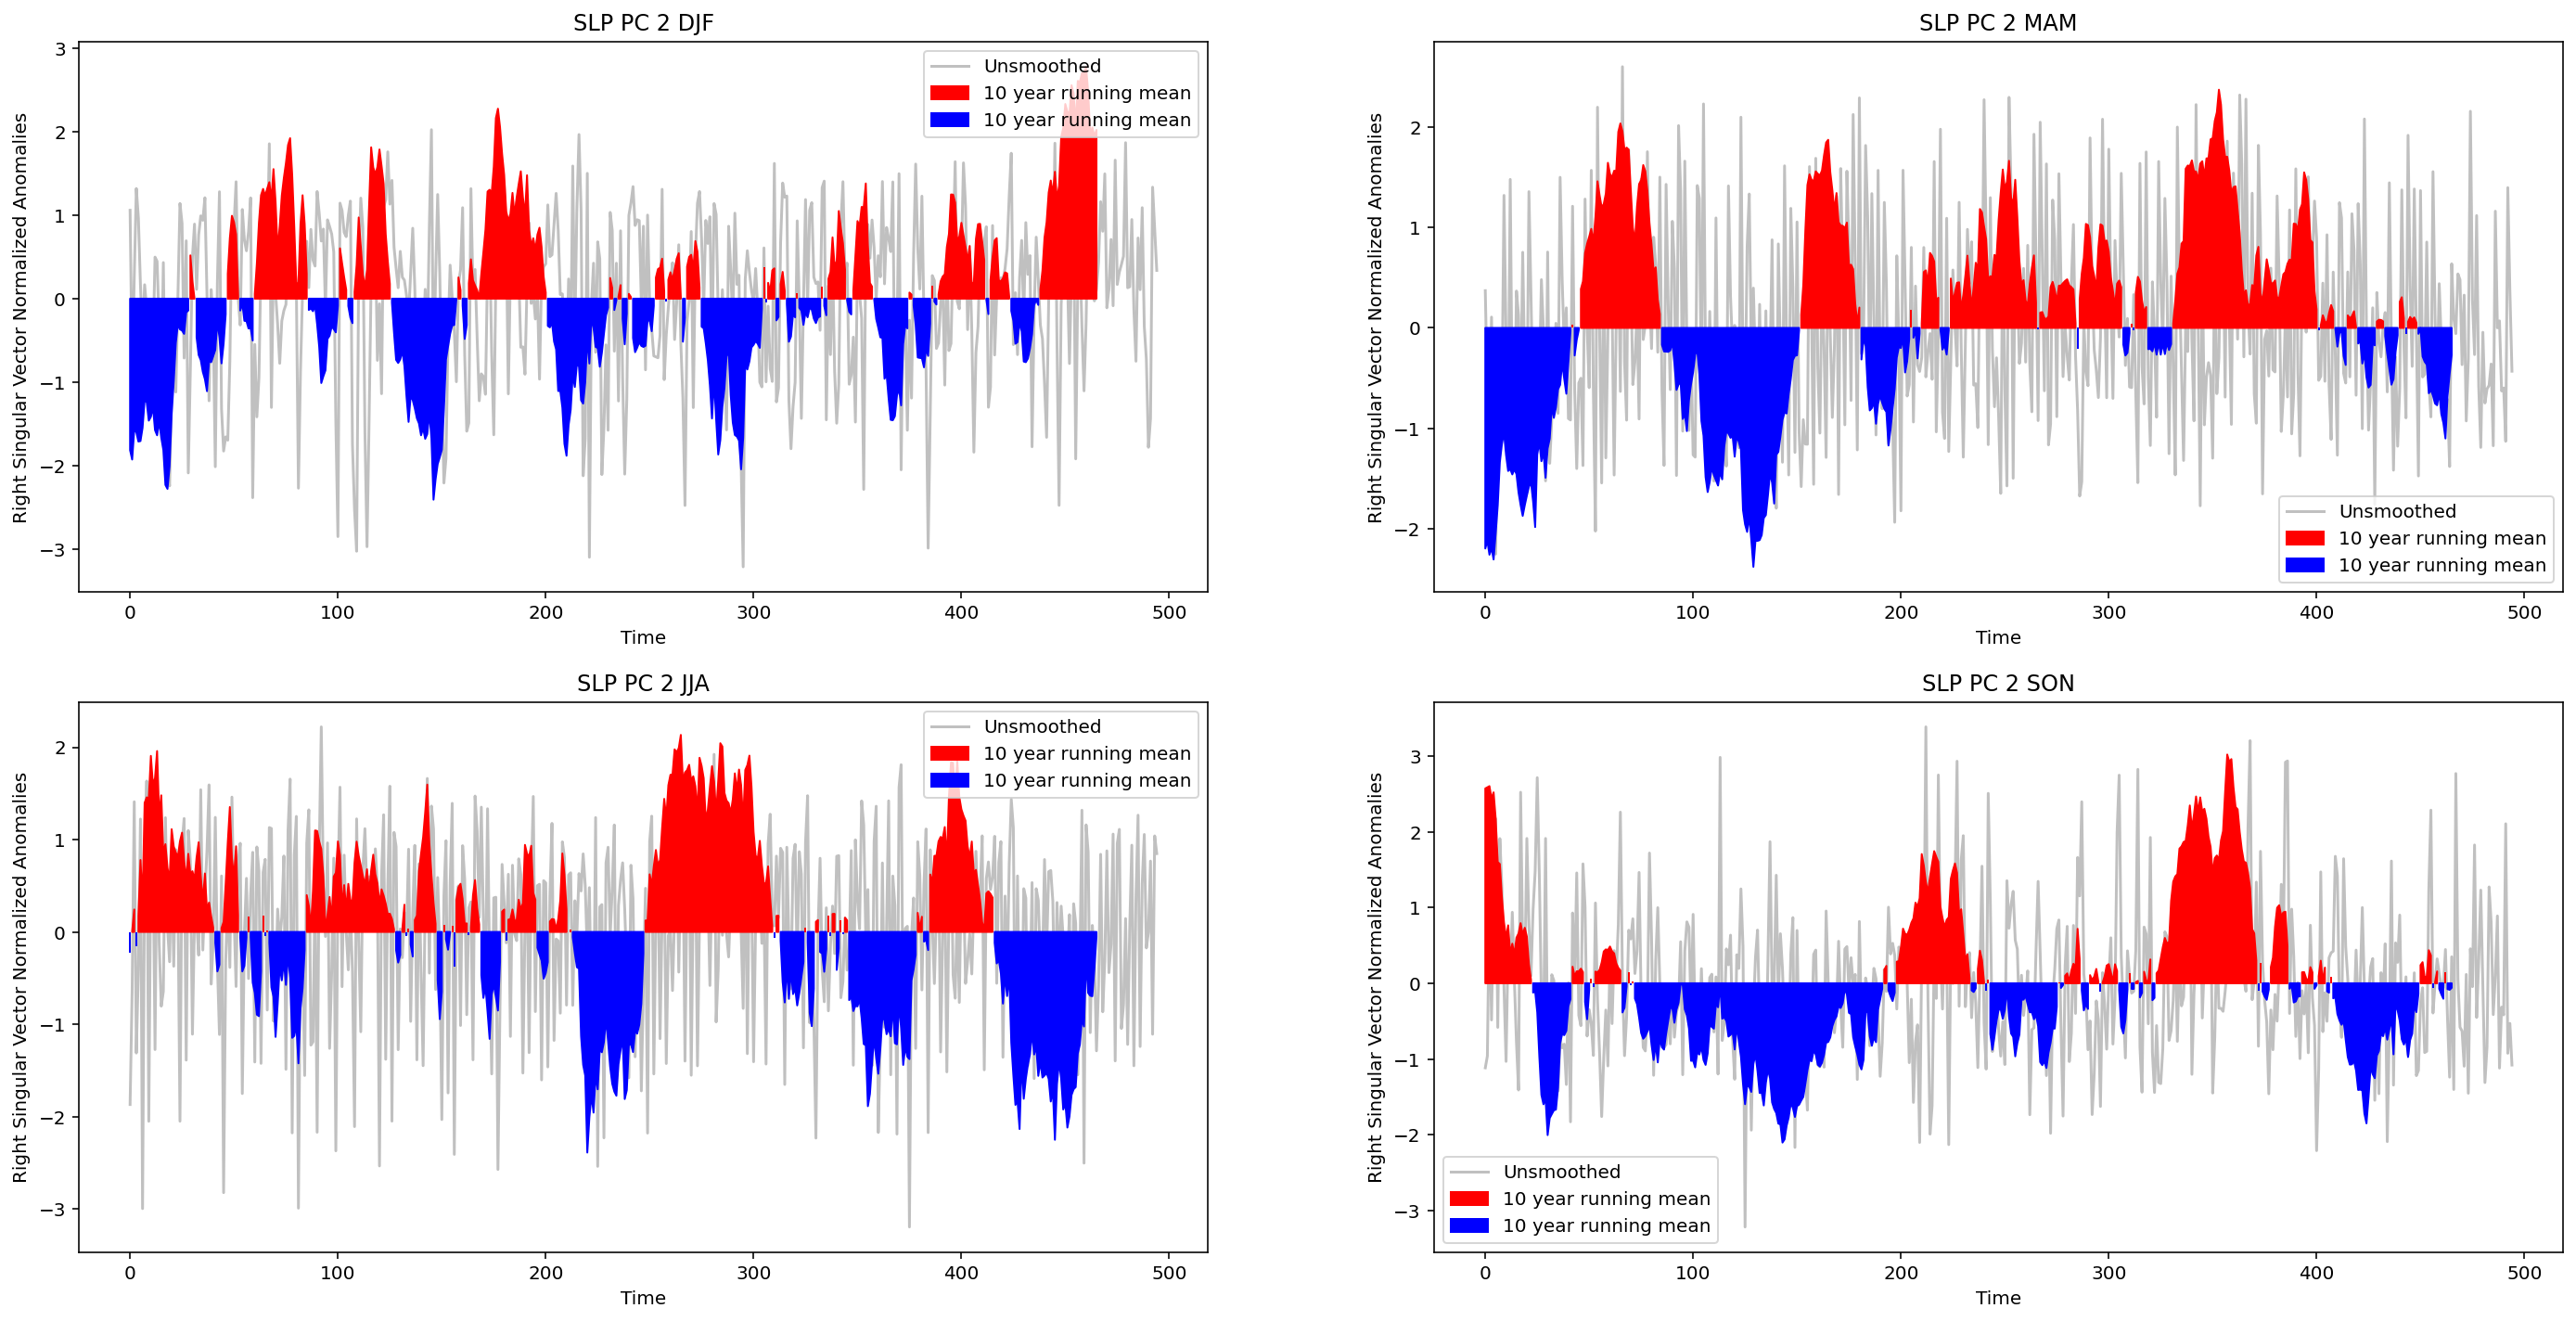

In [ ]:
for singVal in eigenpatterns:
  fig, axs = plt.subplots(2, 2, figsize=[24, 12])
  axlist = axs.flatten()
  for season in SEASONS:
    x = np.arange(0, 495)
    axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal '+singVal[-1]]['normalized'][season], where=eigenpatterns['singVal '+singVal[-1]]['normalized'][season]>0, color='r')
    axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal '+singVal[-1]]['normalized'][season], where=eigenpatterns['singVal '+singVal[-1]]['normalized'][season]<0, color='b')
    if int(singVal[-1])==0:
      axlist[SEASONS.index(season)].set_title('NAO Index (PC 1) '+season)
    else:
      axlist[SEASONS.index(season)].set_title('SLP PC '+str(int(singVal[-1])+1)+' '+season)
    axlist[SEASONS.index(season)].set_ylabel('Right Singular Vector Normalized Anomalies')
    axlist[SEASONS.index(season)].set_xlabel('Time')
    # axlist[SEASONS.index(season)].set_xticks(np.arange(495), ([j for j in psl_allseasons[season].time]))
  plt.show()
  fig, axs = plt.subplots(2, 2, figsize=[24, 12])
  axlist = axs.flatten()
  for season in SEASONS:
    x = np.arange(0, len(nao_smoothed))
    axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal '+singVal[-1]]['smoothed'][season], where=eigenpatterns['singVal '+singVal[-1]]['smoothed'][season]>0, color='r', label='10 year running mean')
    axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal '+singVal[-1]]['smoothed'][season], where=eigenpatterns['singVal '+singVal[-1]]['smoothed'][season]<0, color='b', label='10 year running mean')
    axlist[SEASONS.index(season)].plot(eigenpatterns['singVal '+singVal[-1]]['normalized'][season], 'silver', zorder=0, label='Unsmoothed')
    # plt.plot(x)
    if int(singVal[-1])==0:
      axlist[SEASONS.index(season)].set_title('NAO Index (PC 1) '+season)
    else:
      axlist[SEASONS.index(season)].set_title('SLP PC '+str(int(singVal[-1])+1)+' '+season)
    axlist[SEASONS.index(season)].set_ylabel('Right Singular Vector Normalized Anomalies')
    axlist[SEASONS.index(season)].set_xlabel('Time')
    axlist[SEASONS.index(season)].legend()

In [ ]:
psl_ssp585

activity_id institution_id  ... dcpp_init_year   version
98507         CMIP           NCAR  ...            NaN  20190313
98852         CMIP           NCAR  ...            NaN  20190514
99192         CMIP           NCAR  ...            NaN  20190308
99608         CMIP           NCAR  ...            NaN  20190308
99995         CMIP           NCAR  ...            NaN  20190308
100381        CMIP           NCAR  ...            NaN  20190308
100750        CMIP           NCAR  ...            NaN  20190308
101119        CMIP           NCAR  ...            NaN  20190308
101490        CMIP           NCAR  ...            NaN  20190311
101863        CMIP           NCAR  ...            NaN  20190311
102235        CMIP           NCAR  ...            NaN  20190311

[11 rows x 11 columns]

Plotting the moving average of the normalized anomalies for every ensemble member of the CESM2 model's historical simulation:

0
DJF
MAM
JJA
SON


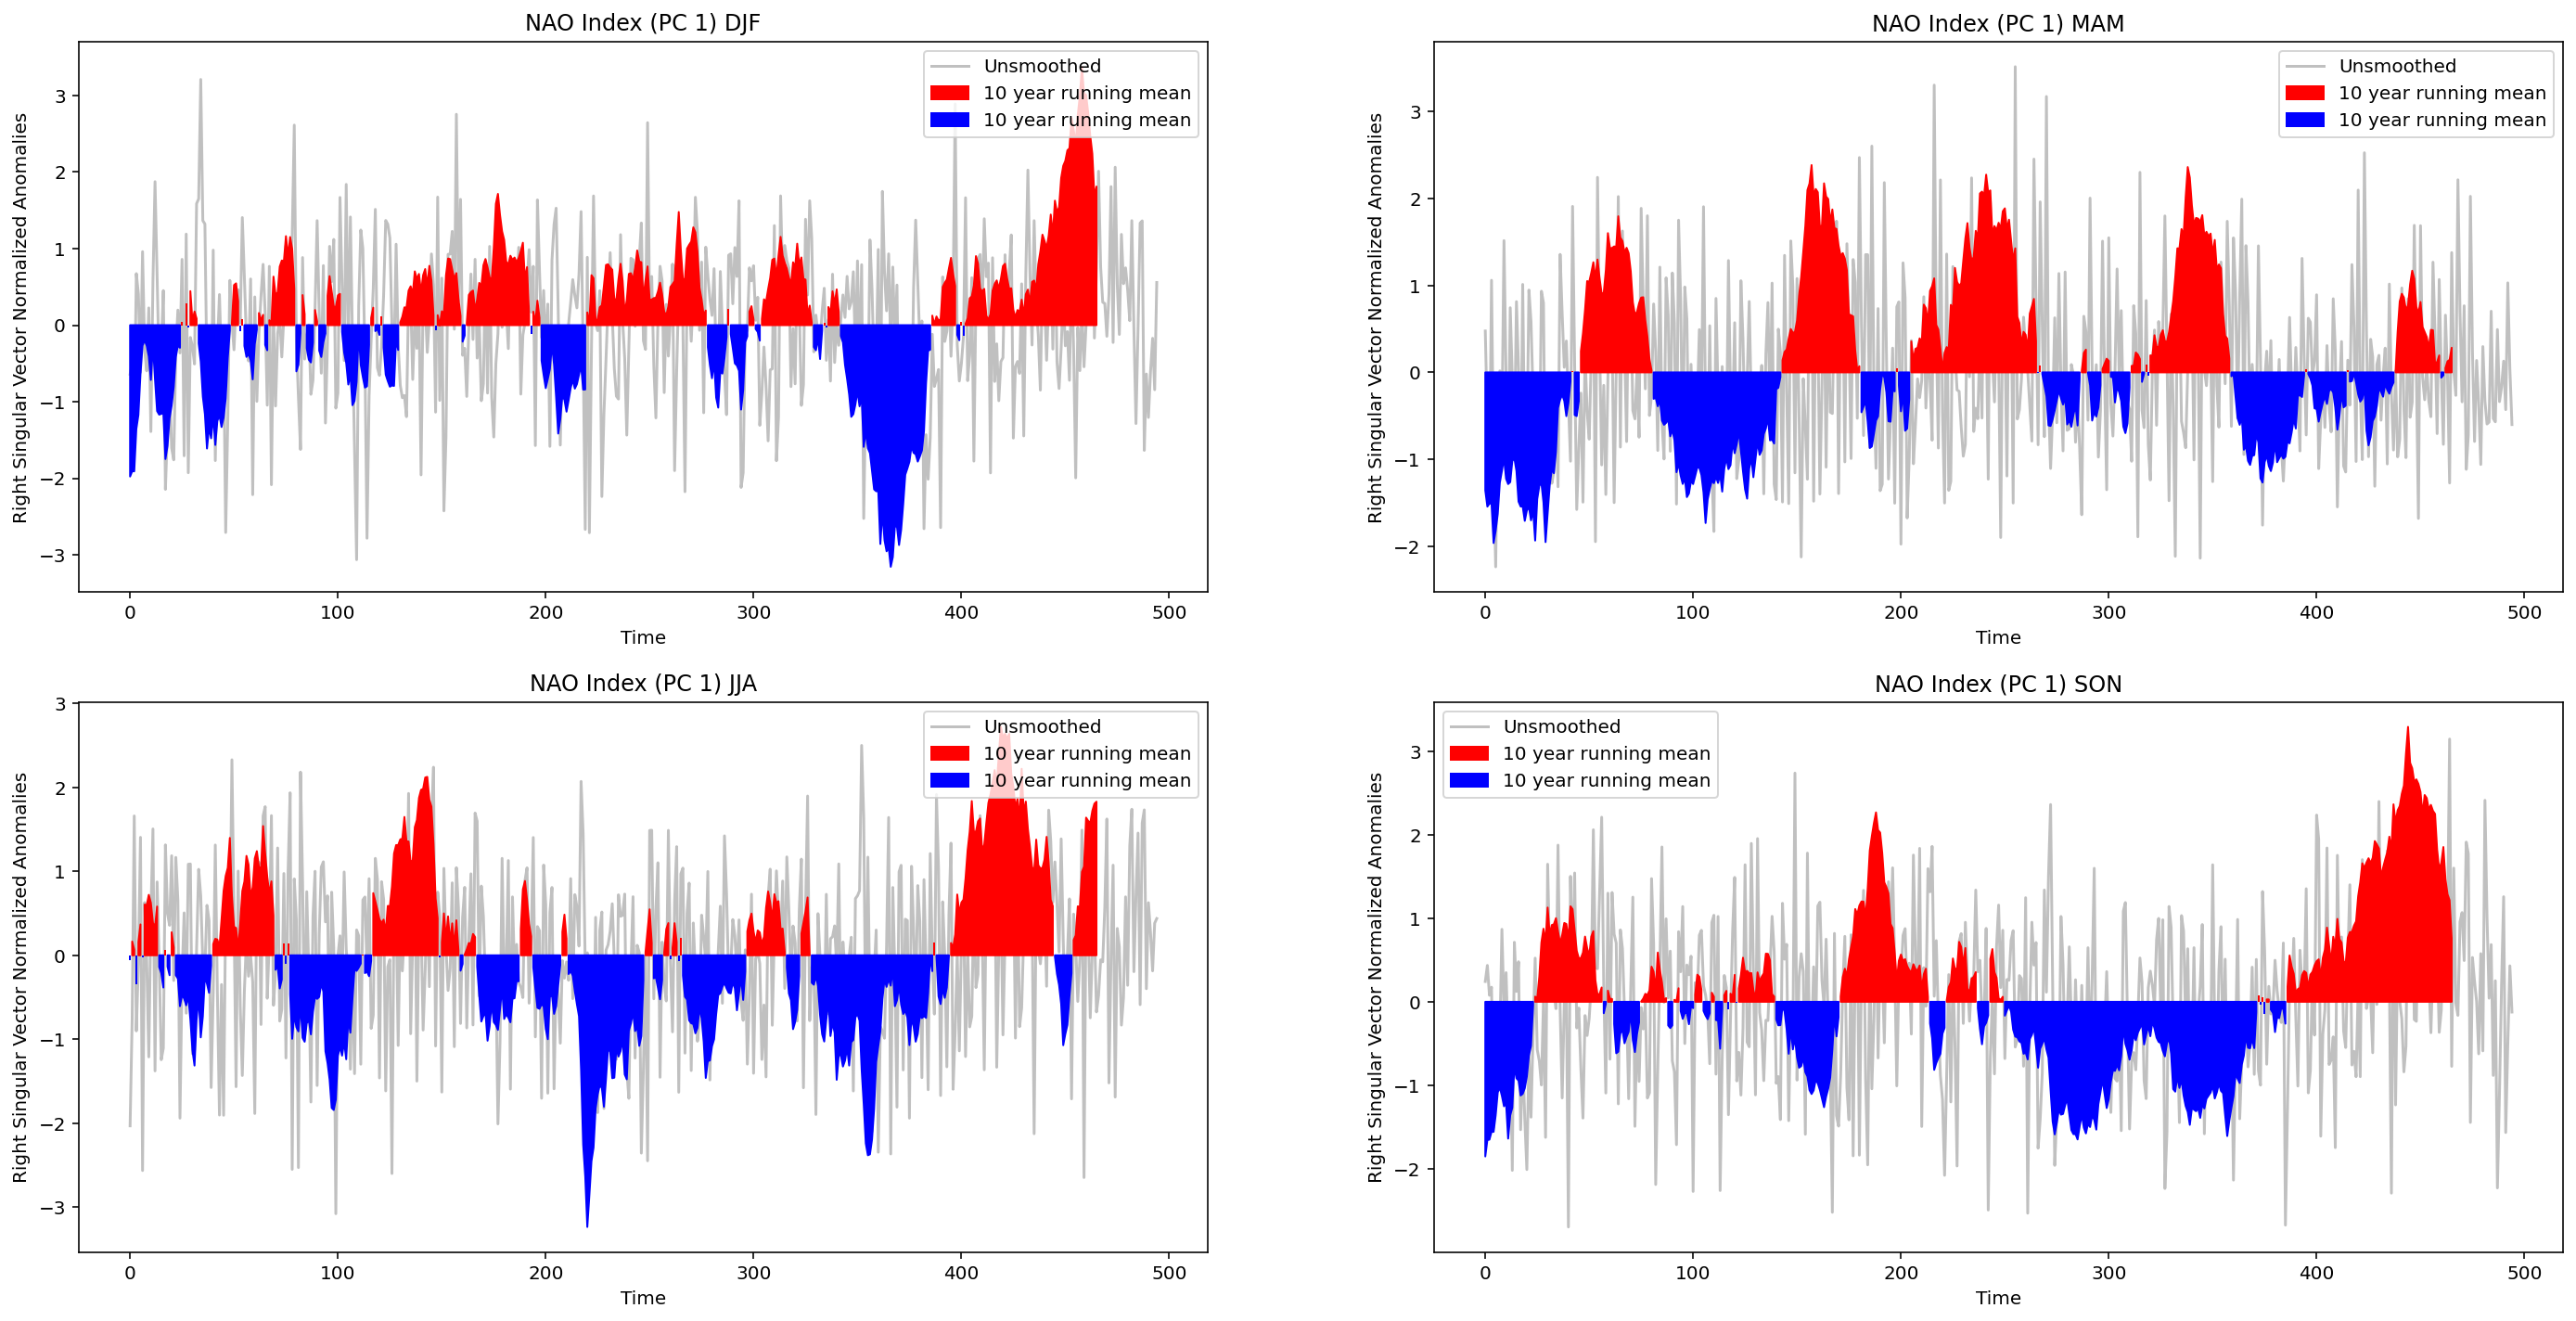

1
DJF
MAM
JJA
SON


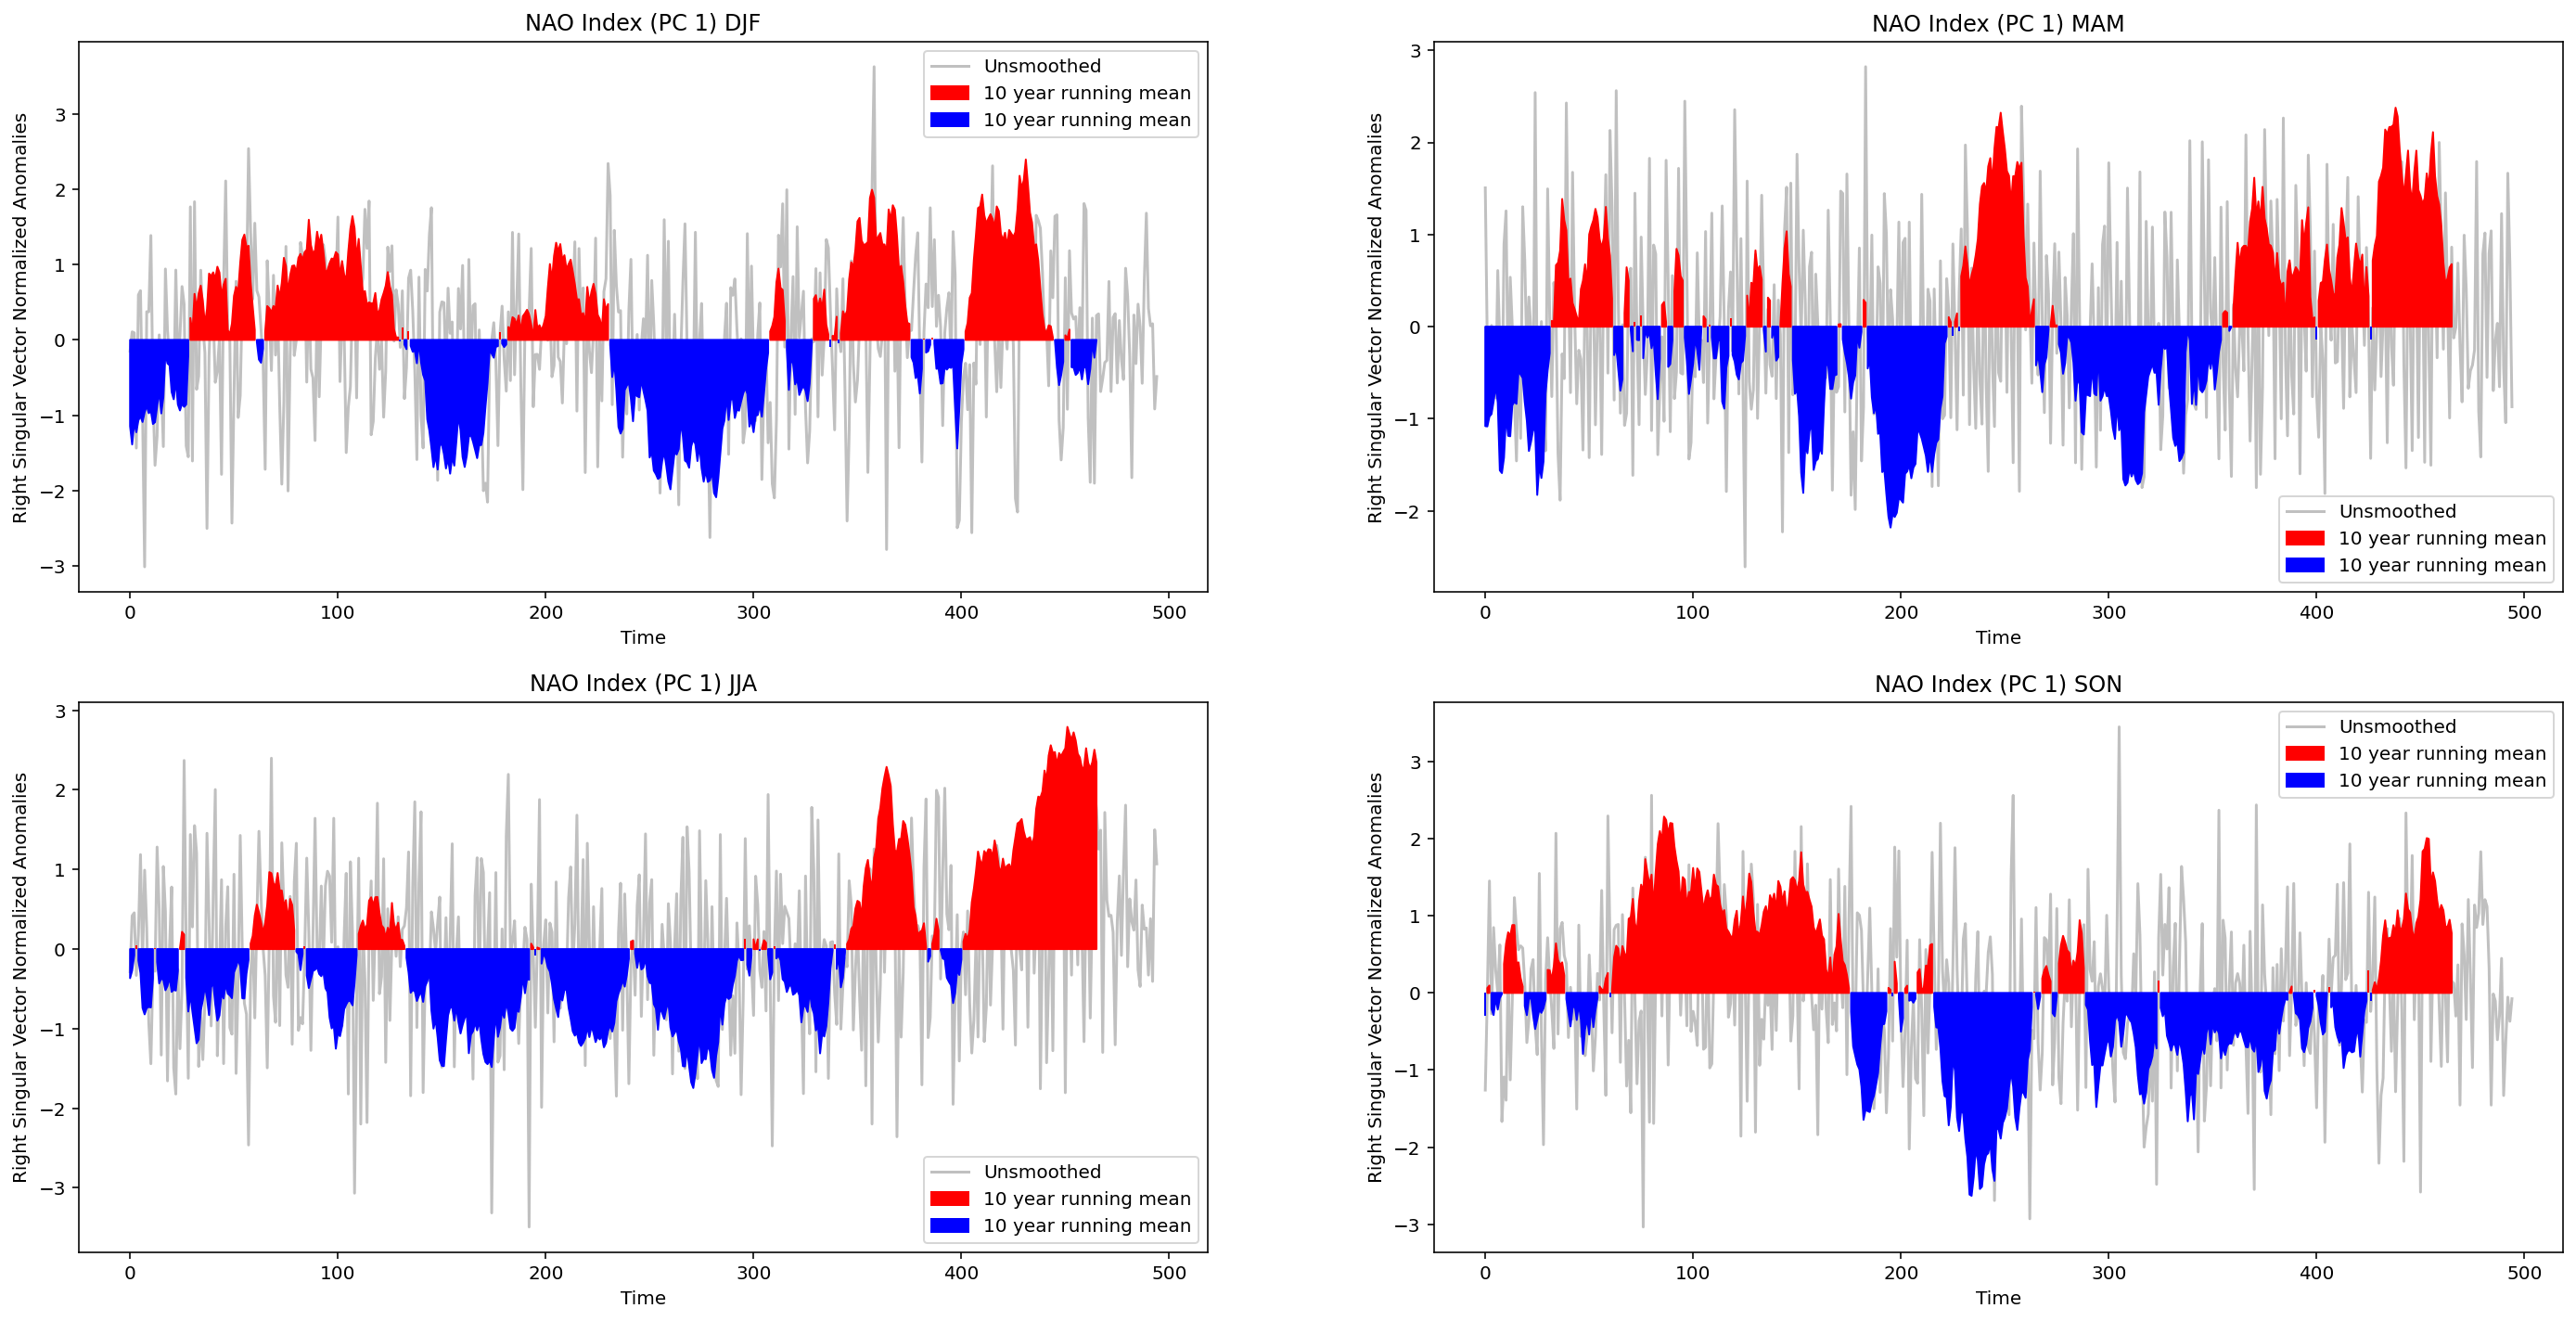

2
DJF
MAM
JJA
SON


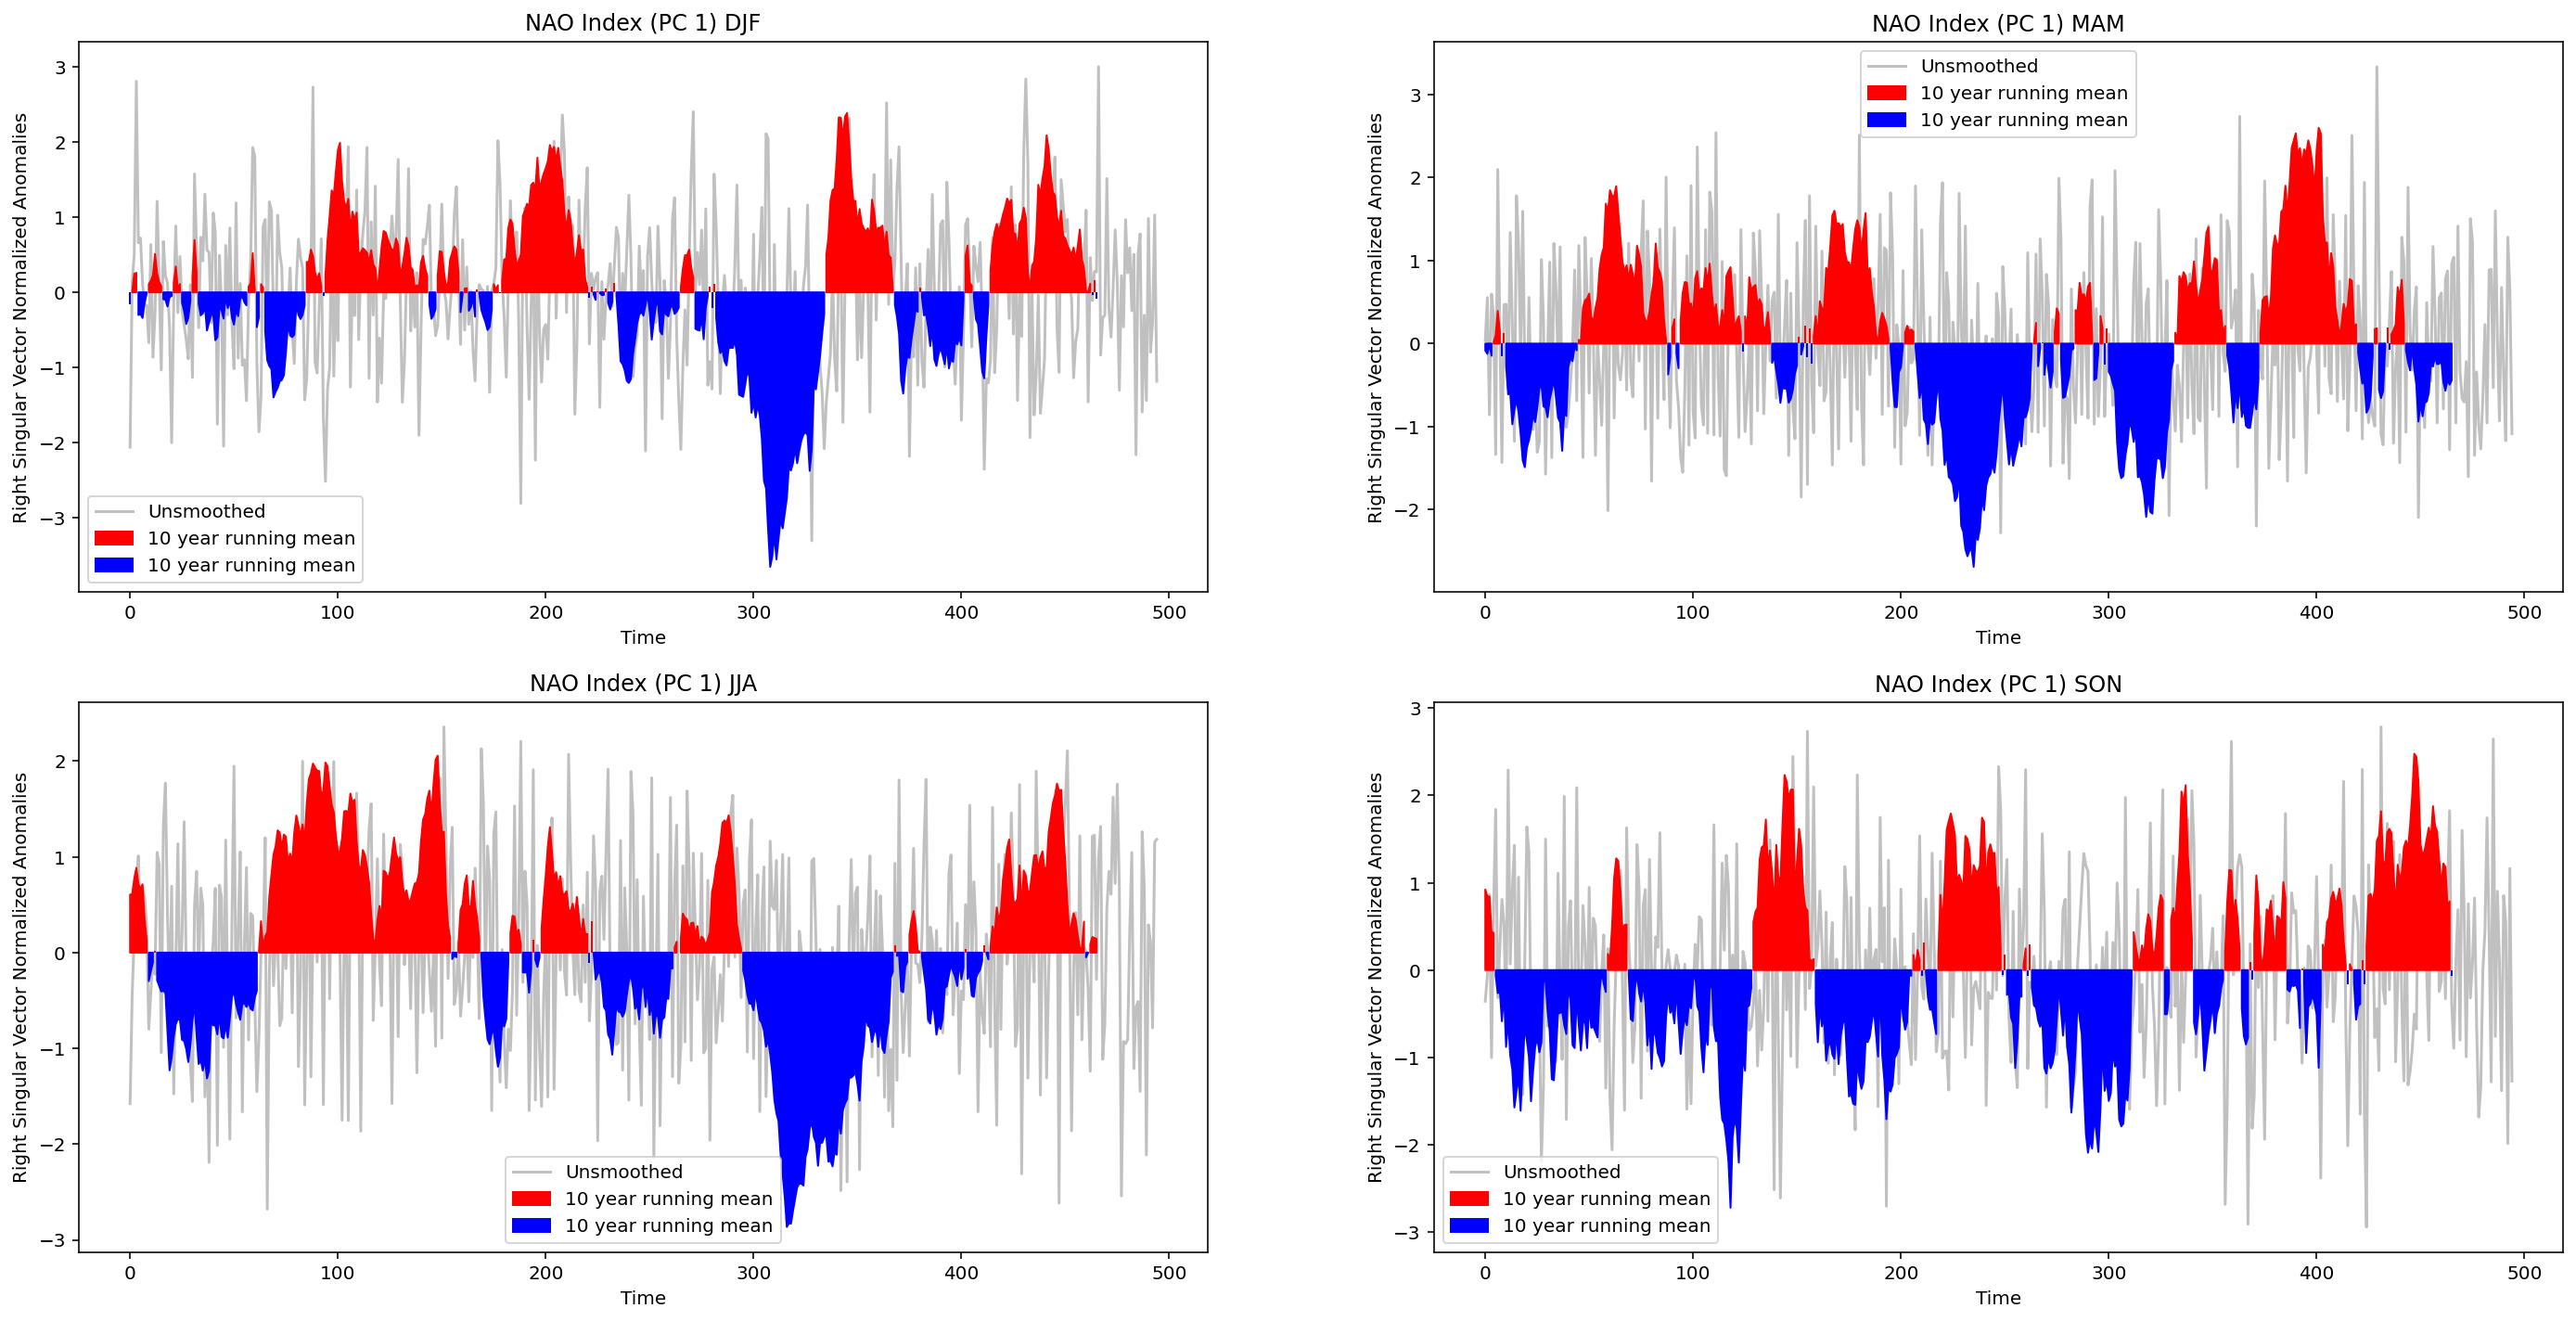

3
DJF
MAM
JJA
SON


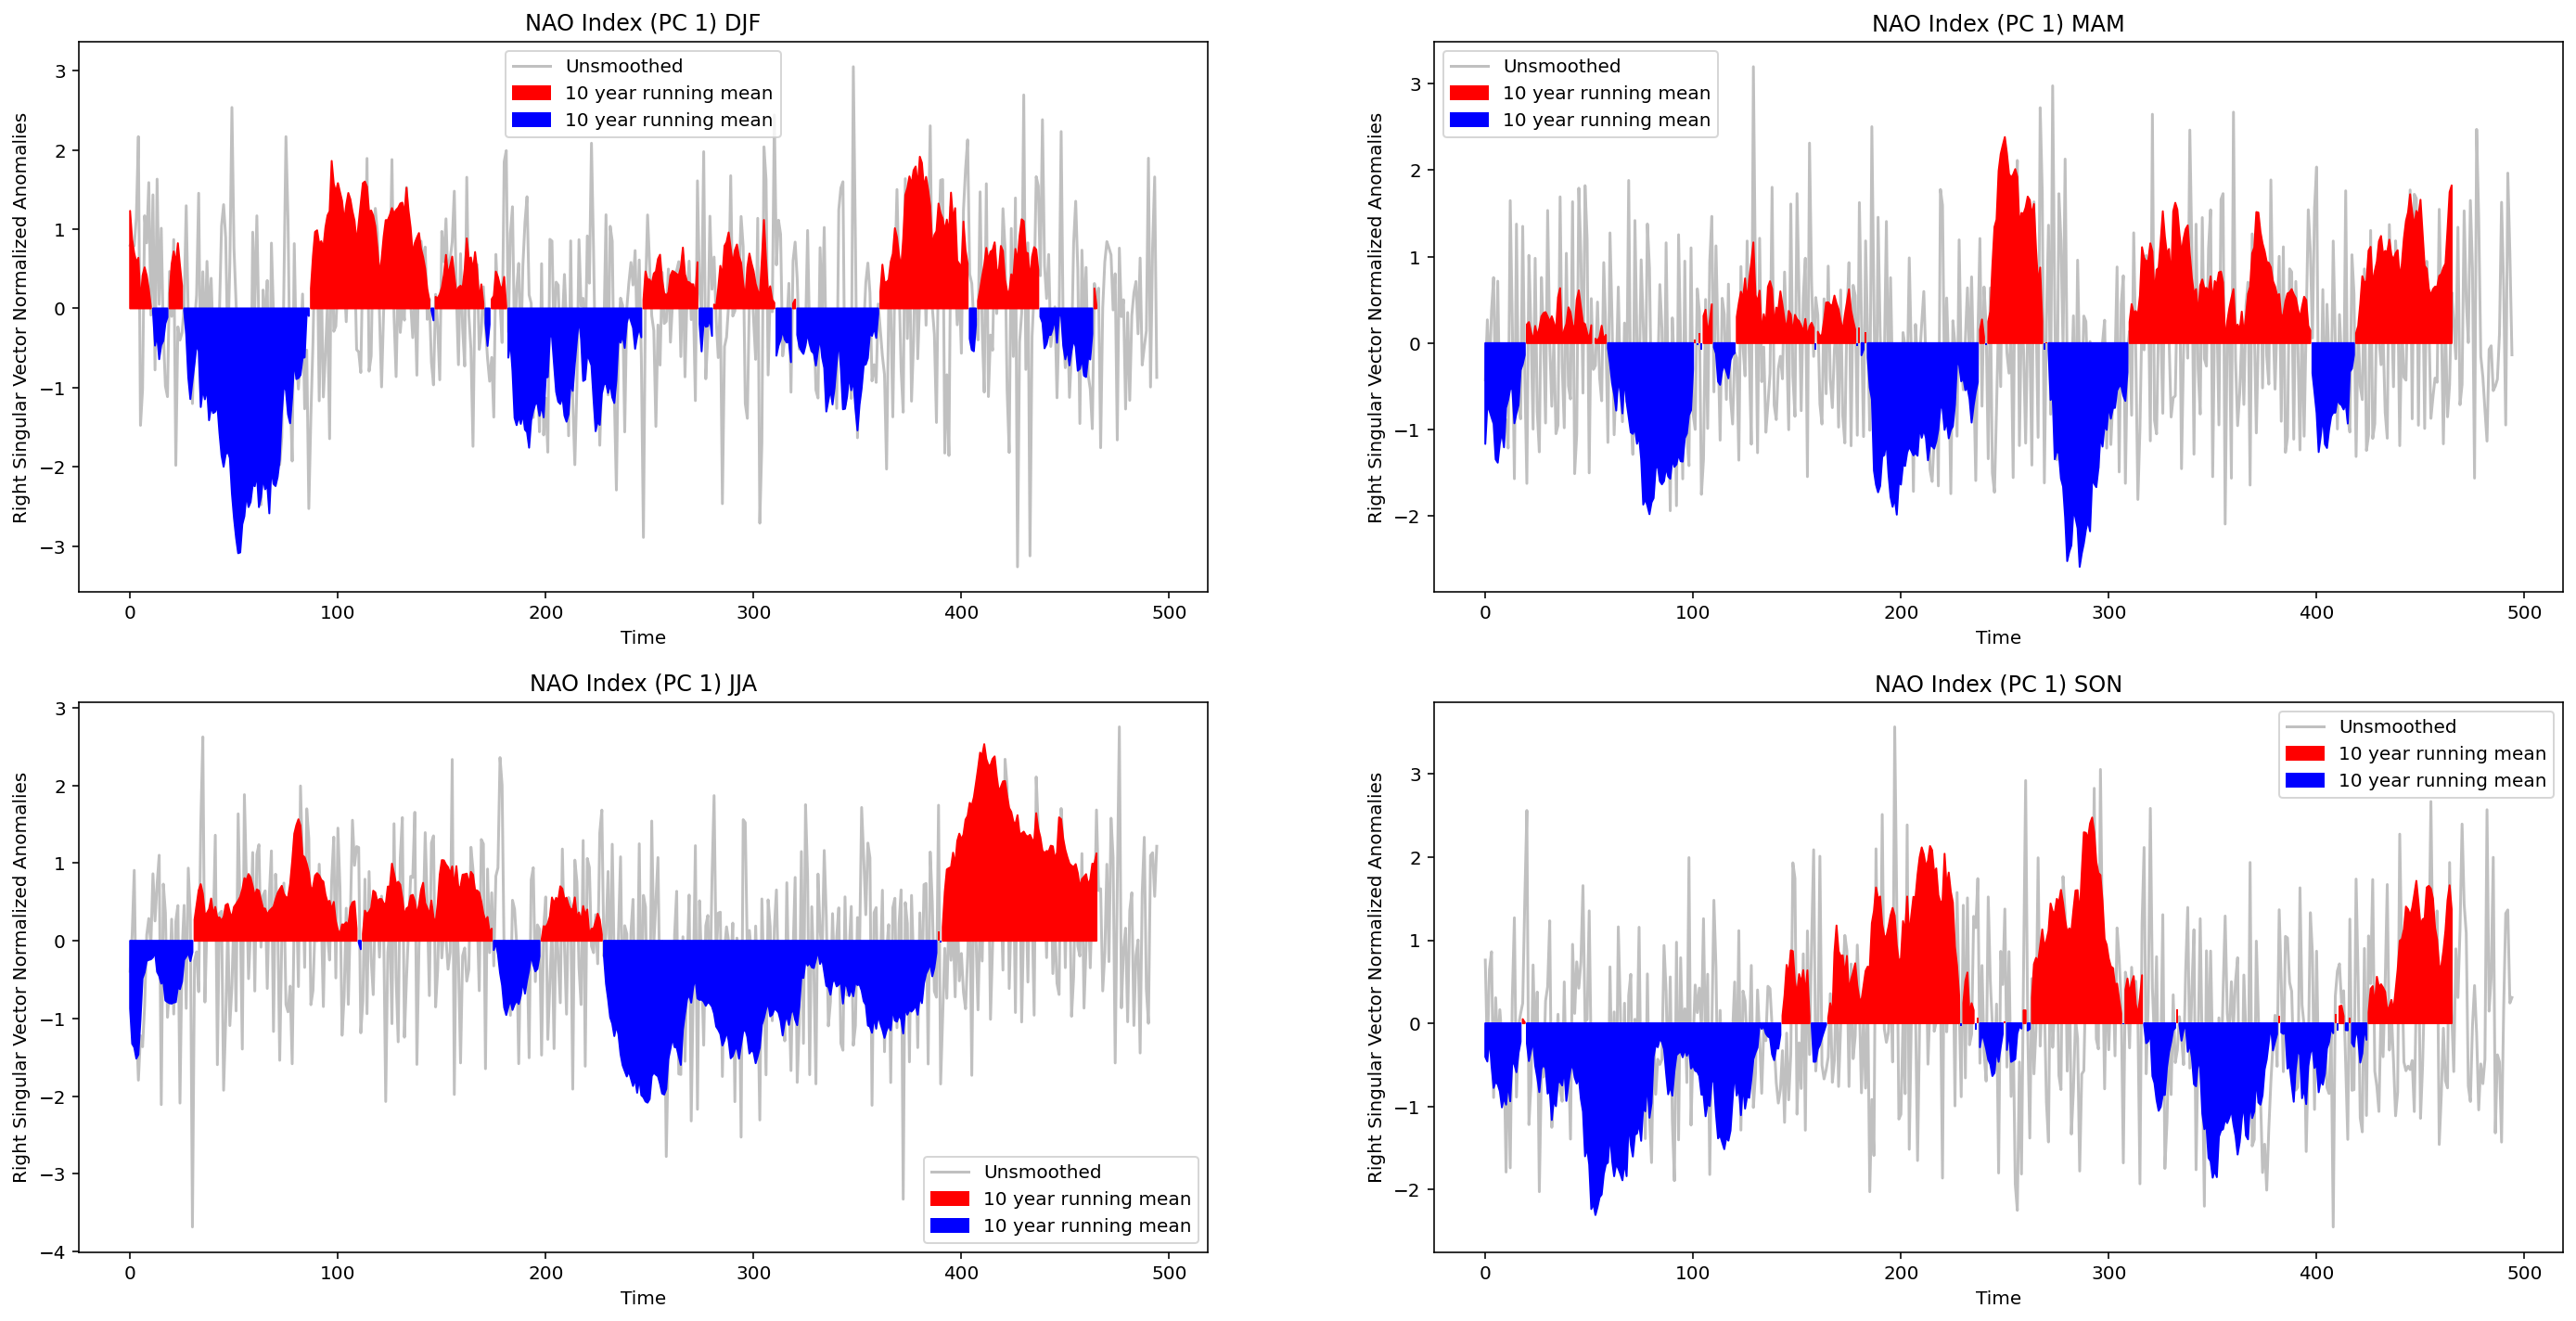

4
DJF
MAM
JJA
SON


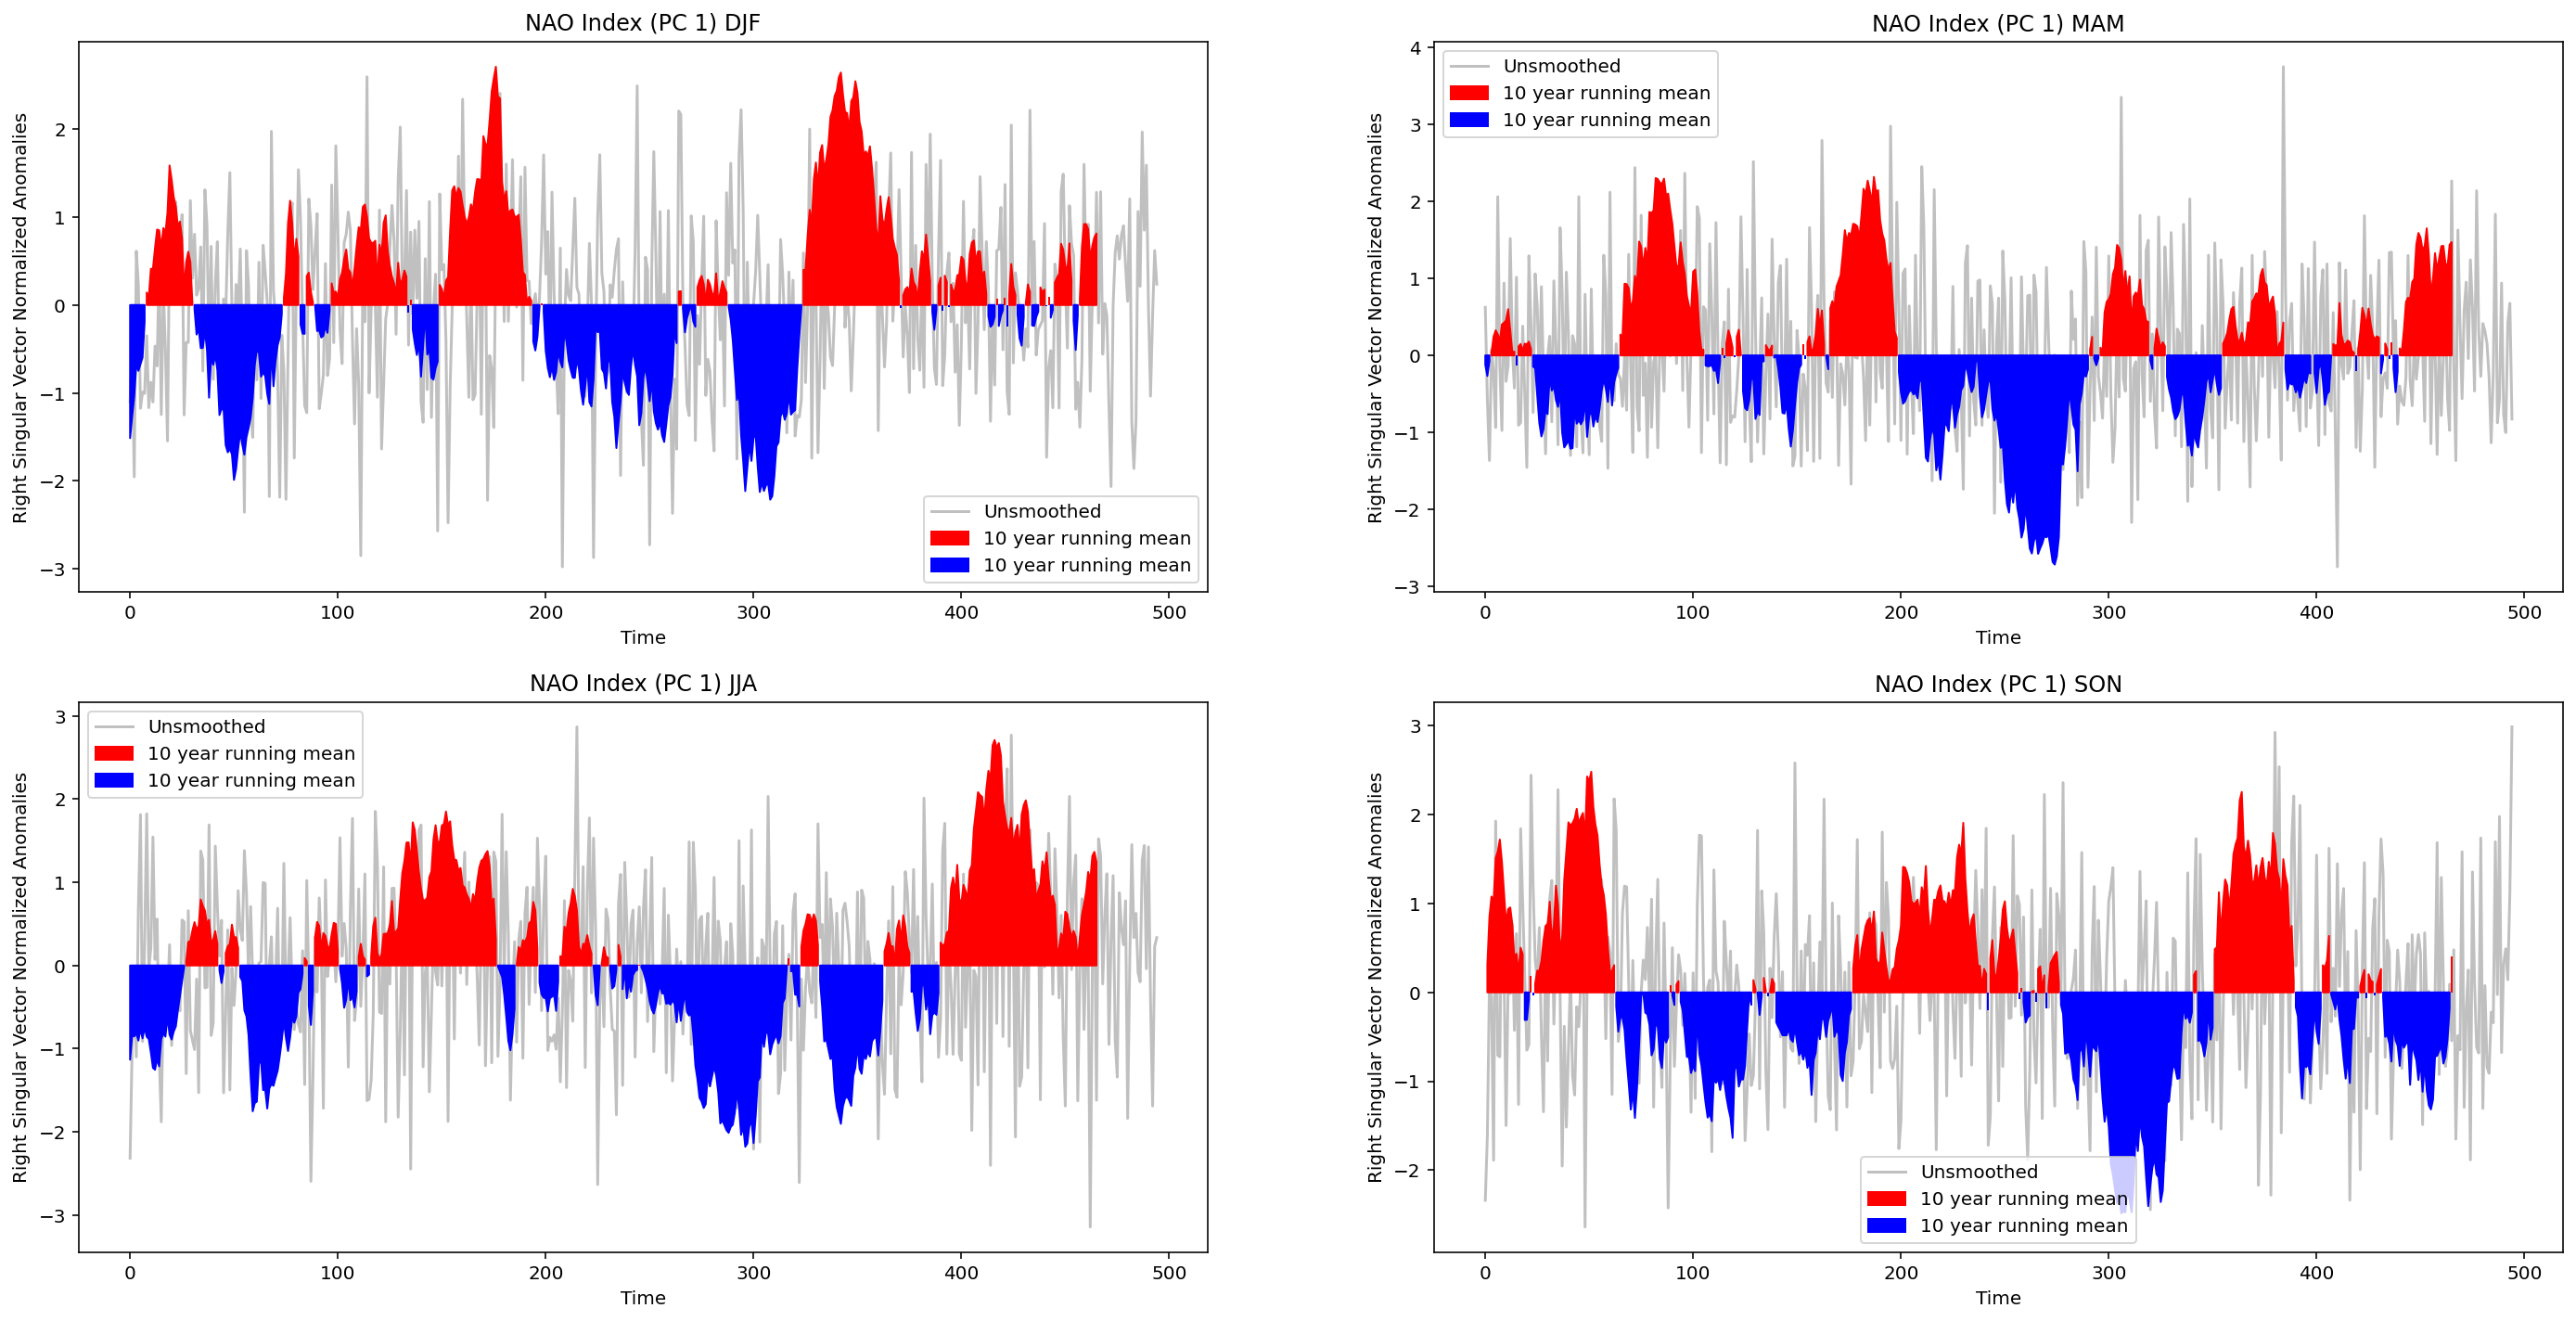

5
DJF
MAM
JJA
SON


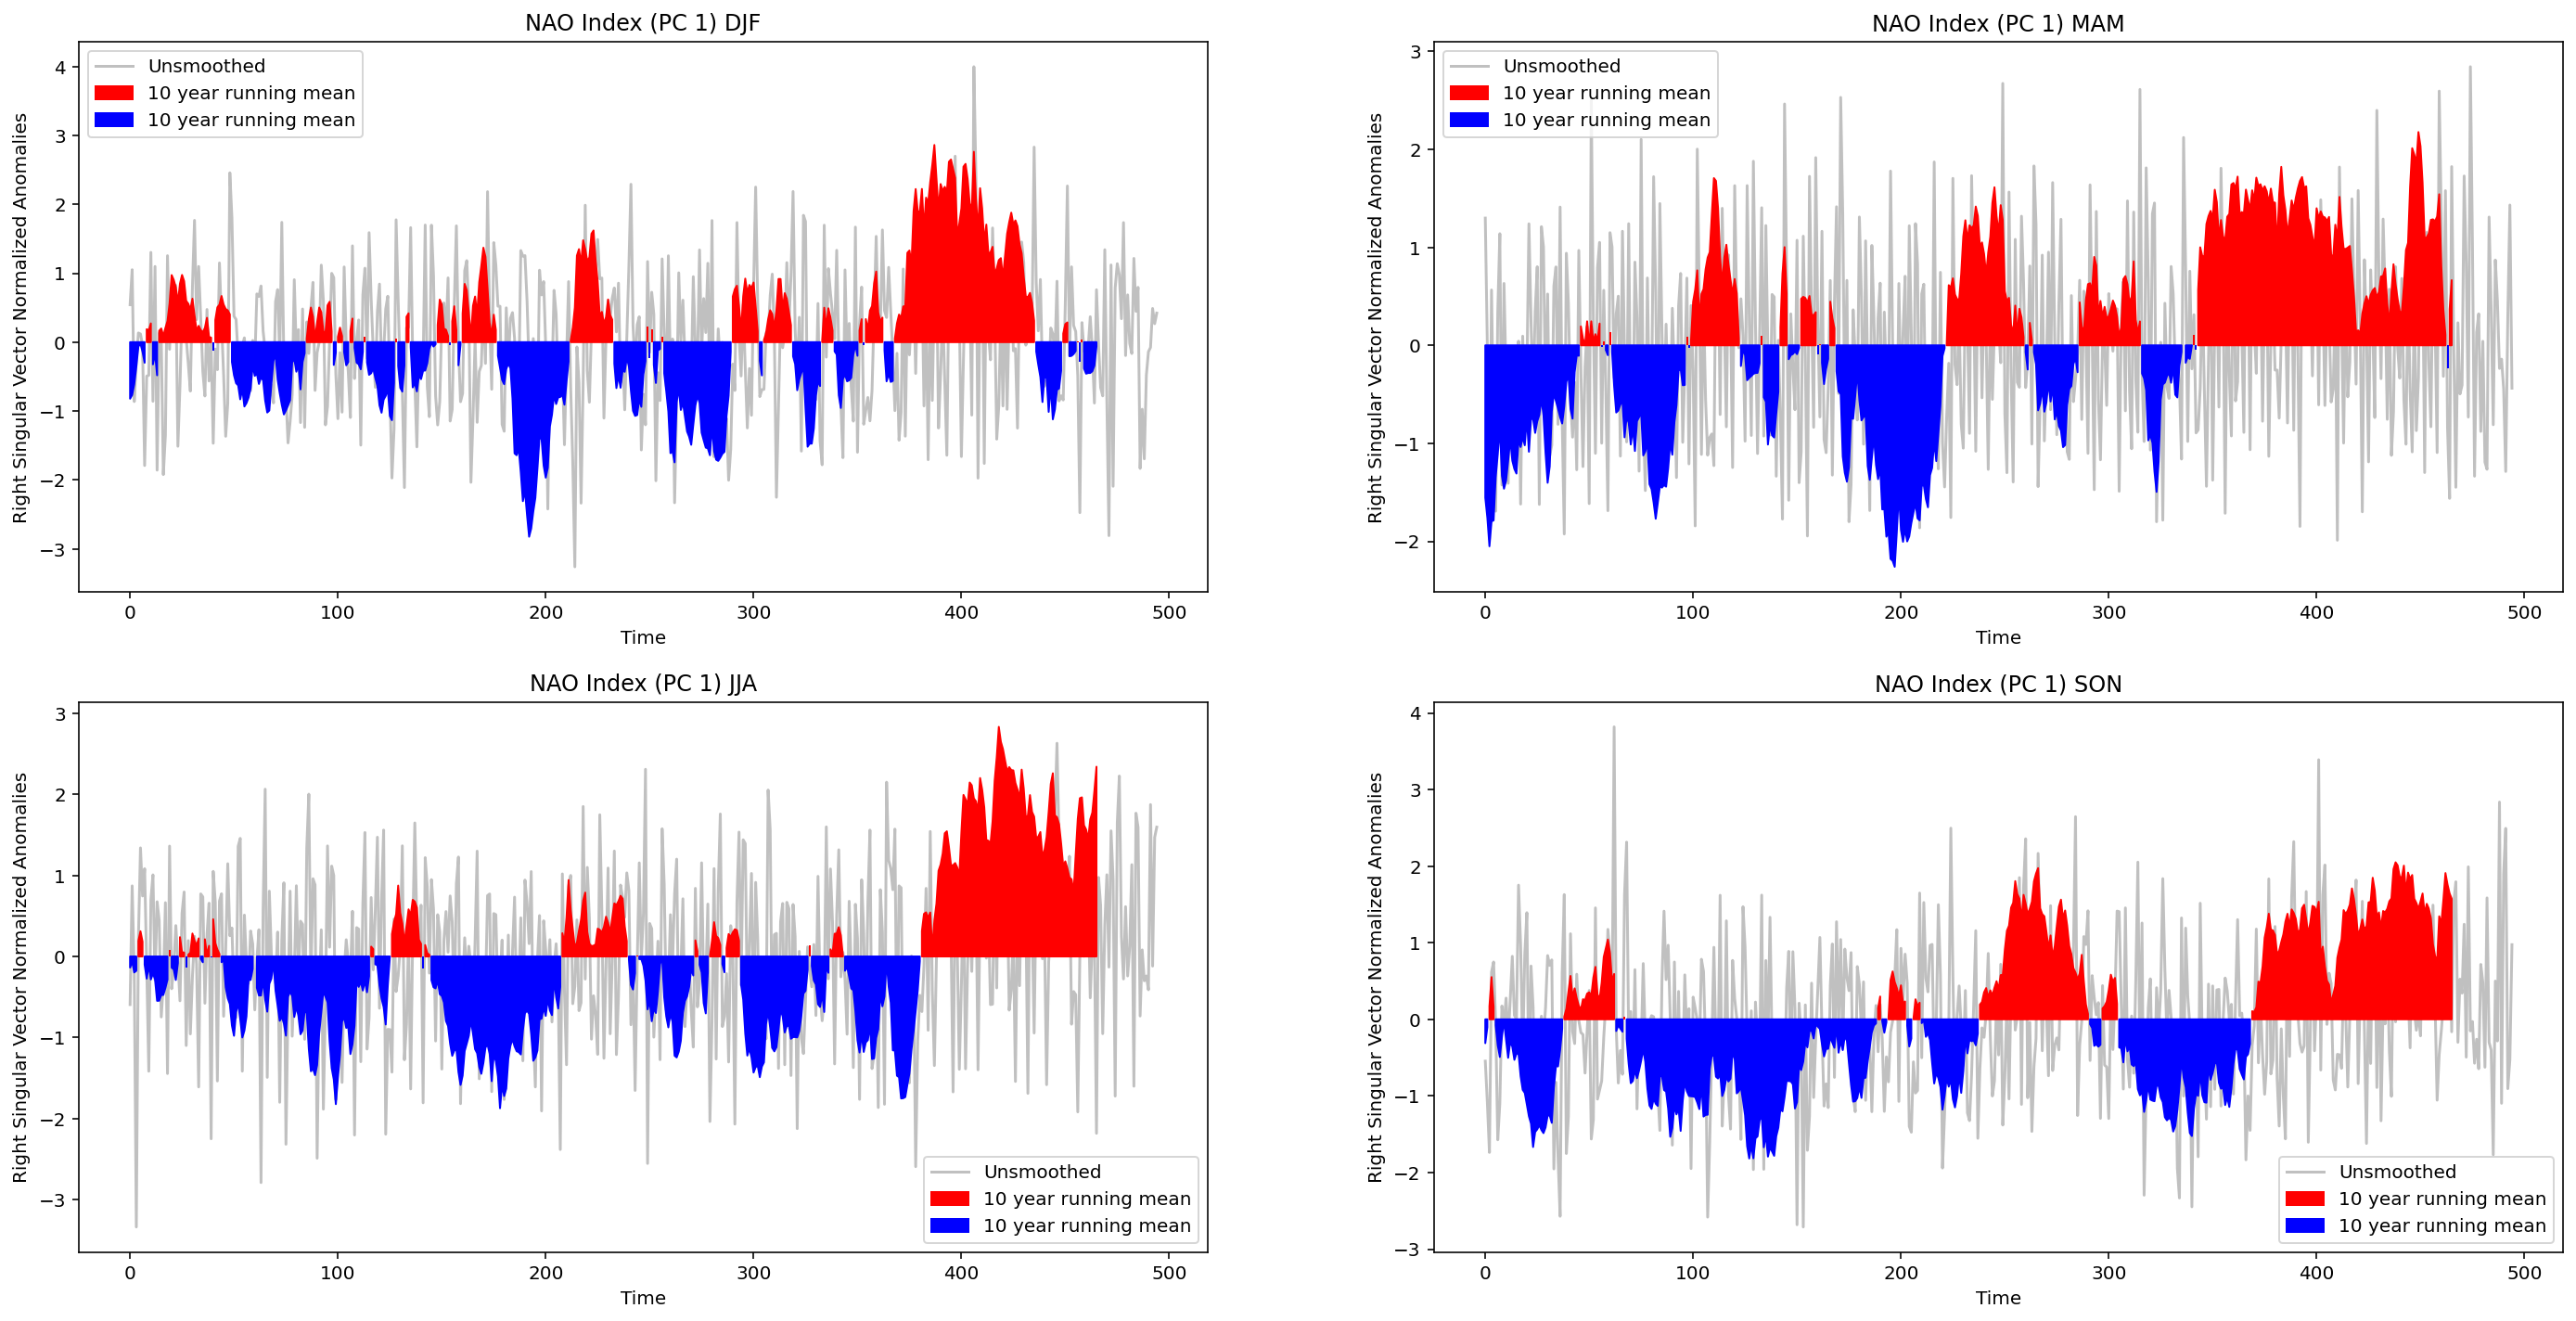

6
DJF
MAM
JJA
SON


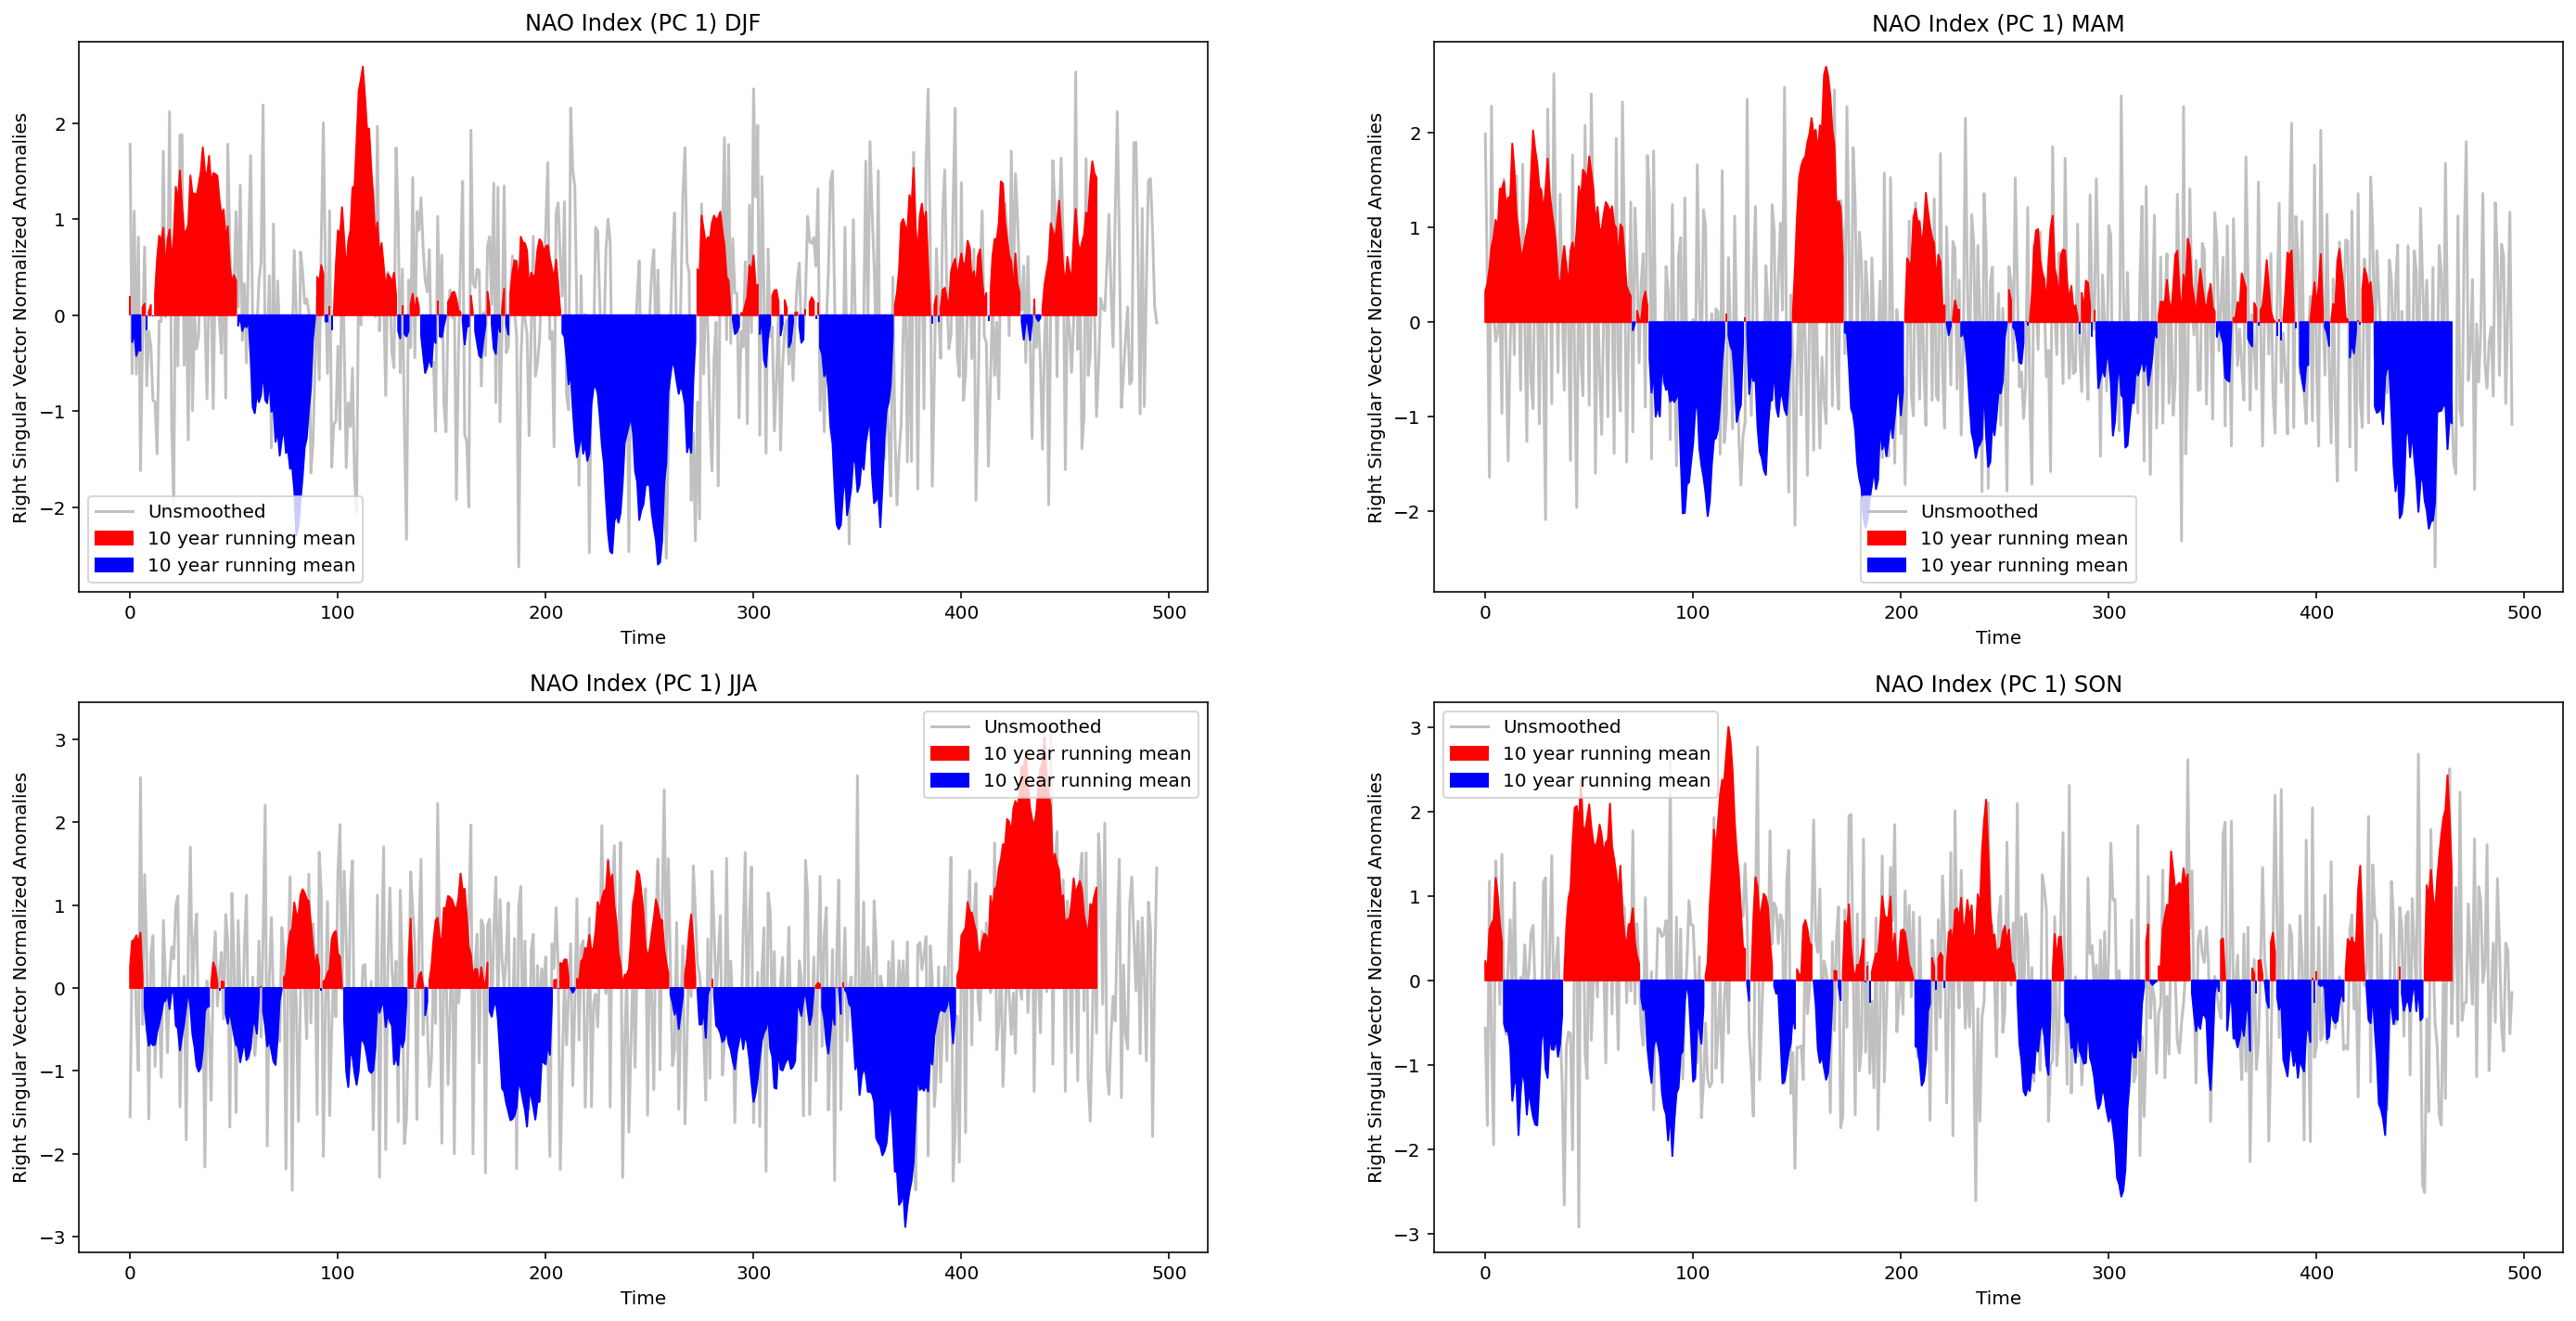

7
DJF
MAM
JJA
SON


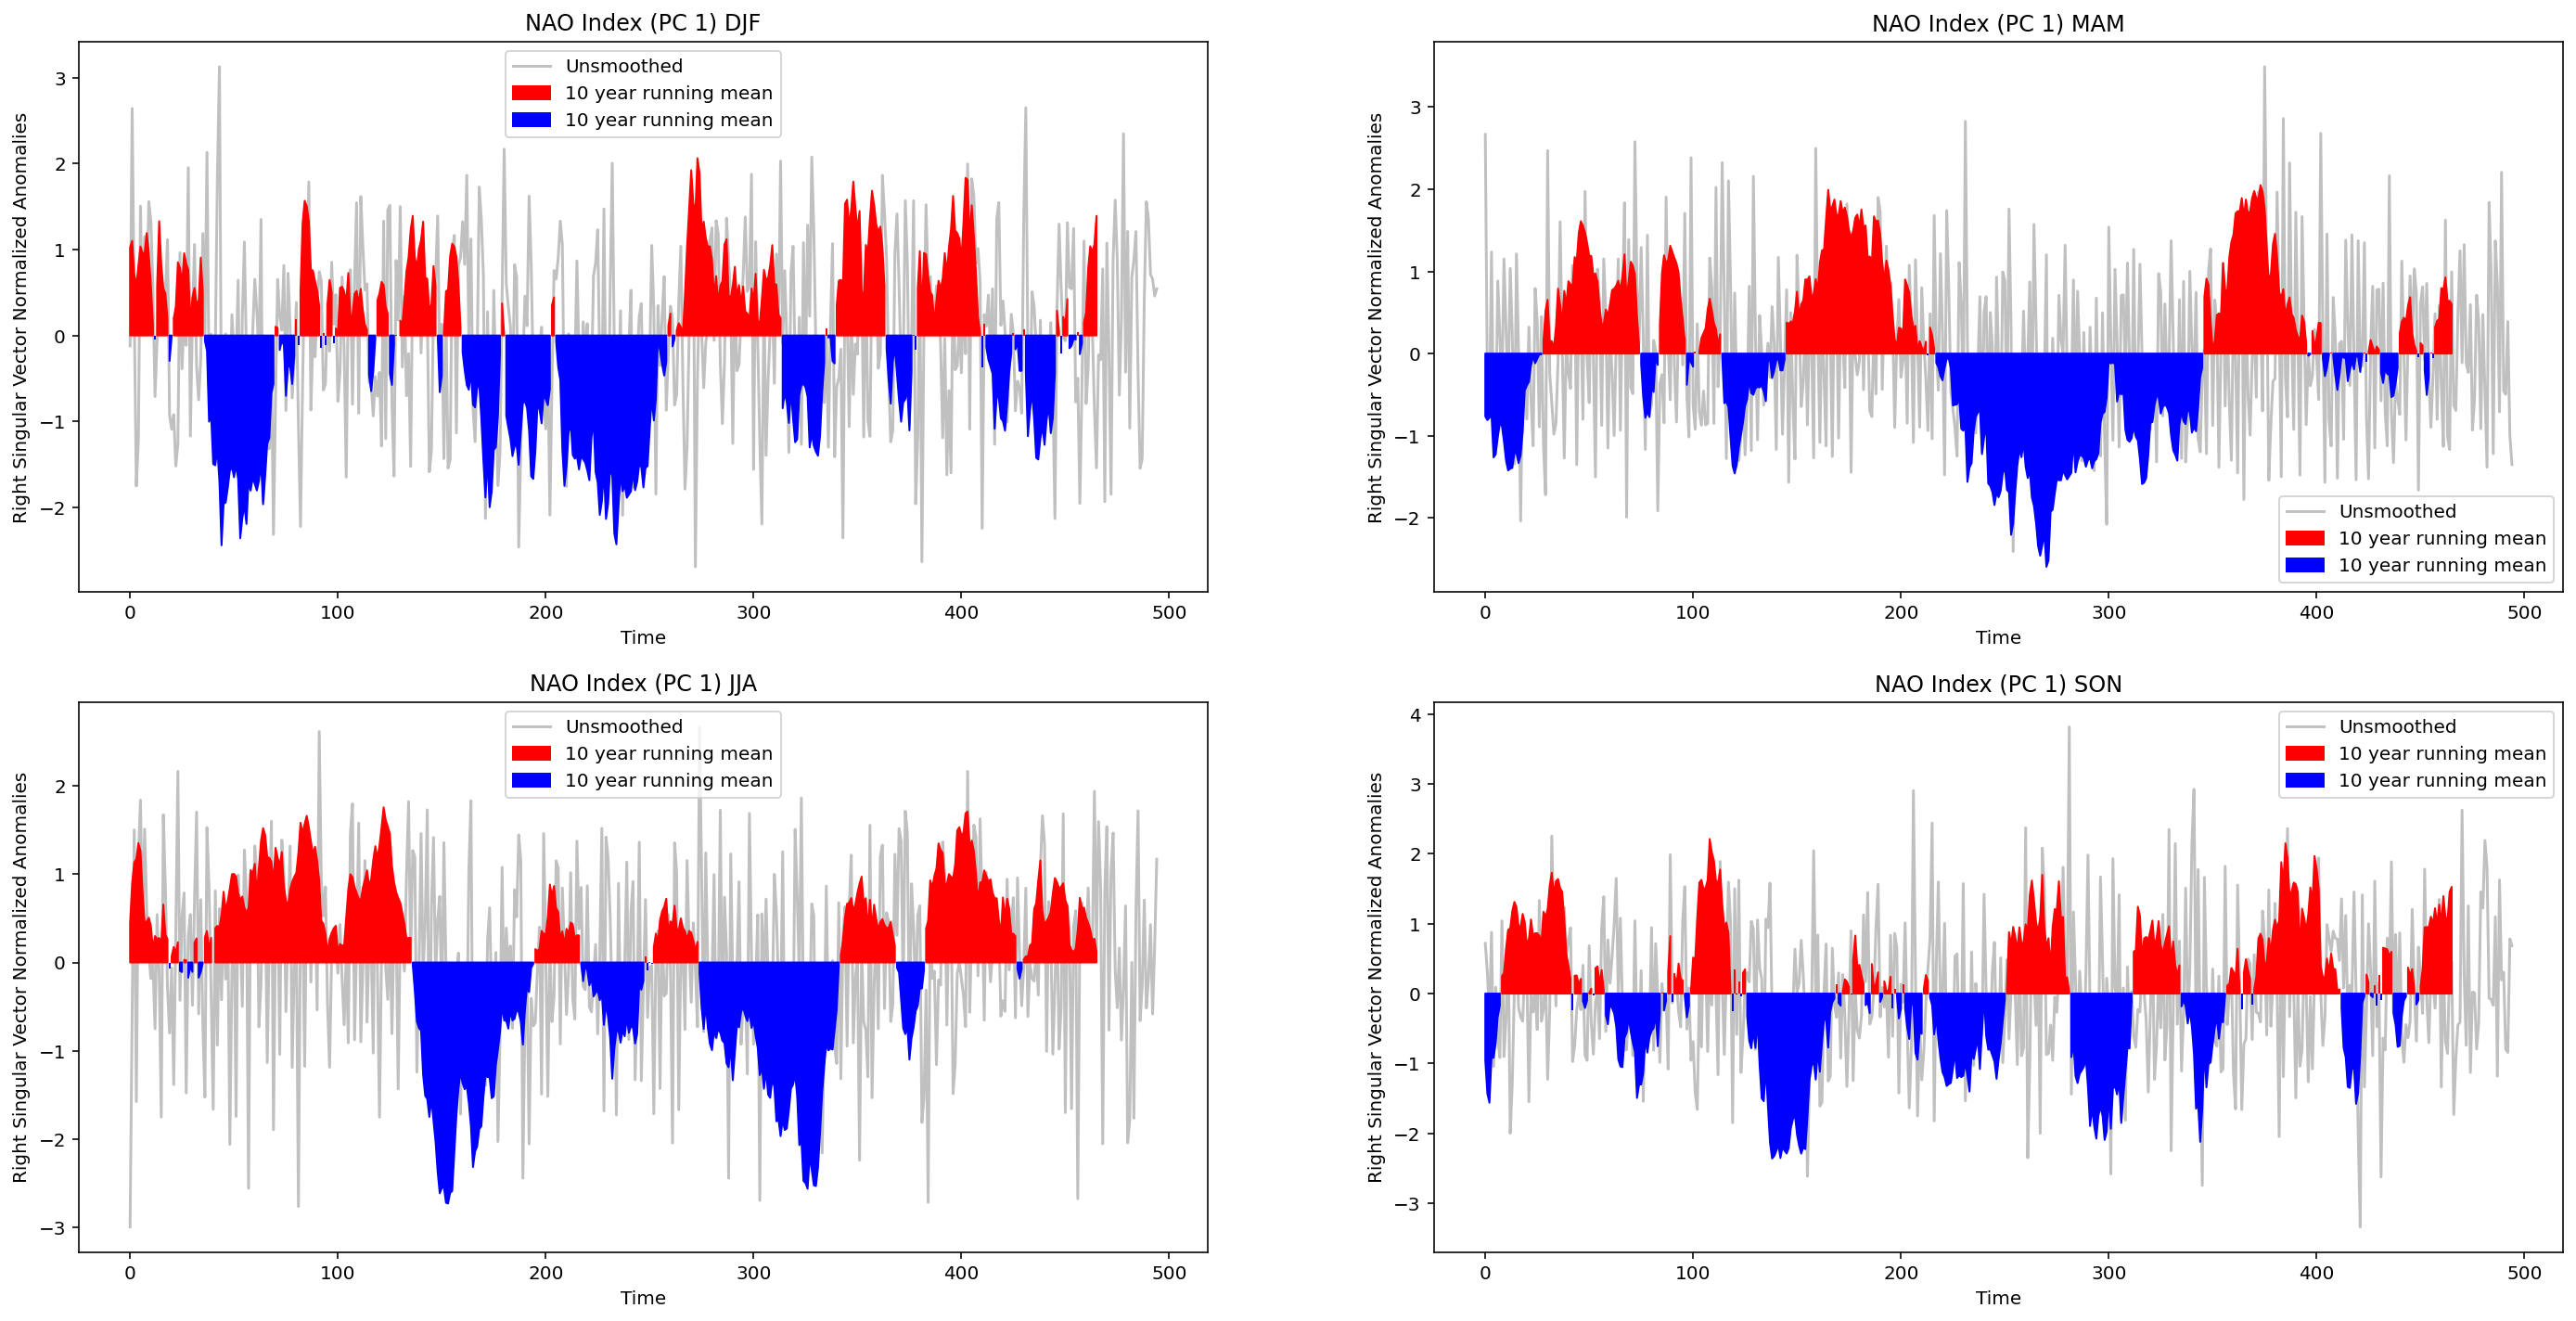

8
DJF
MAM
JJA
SON


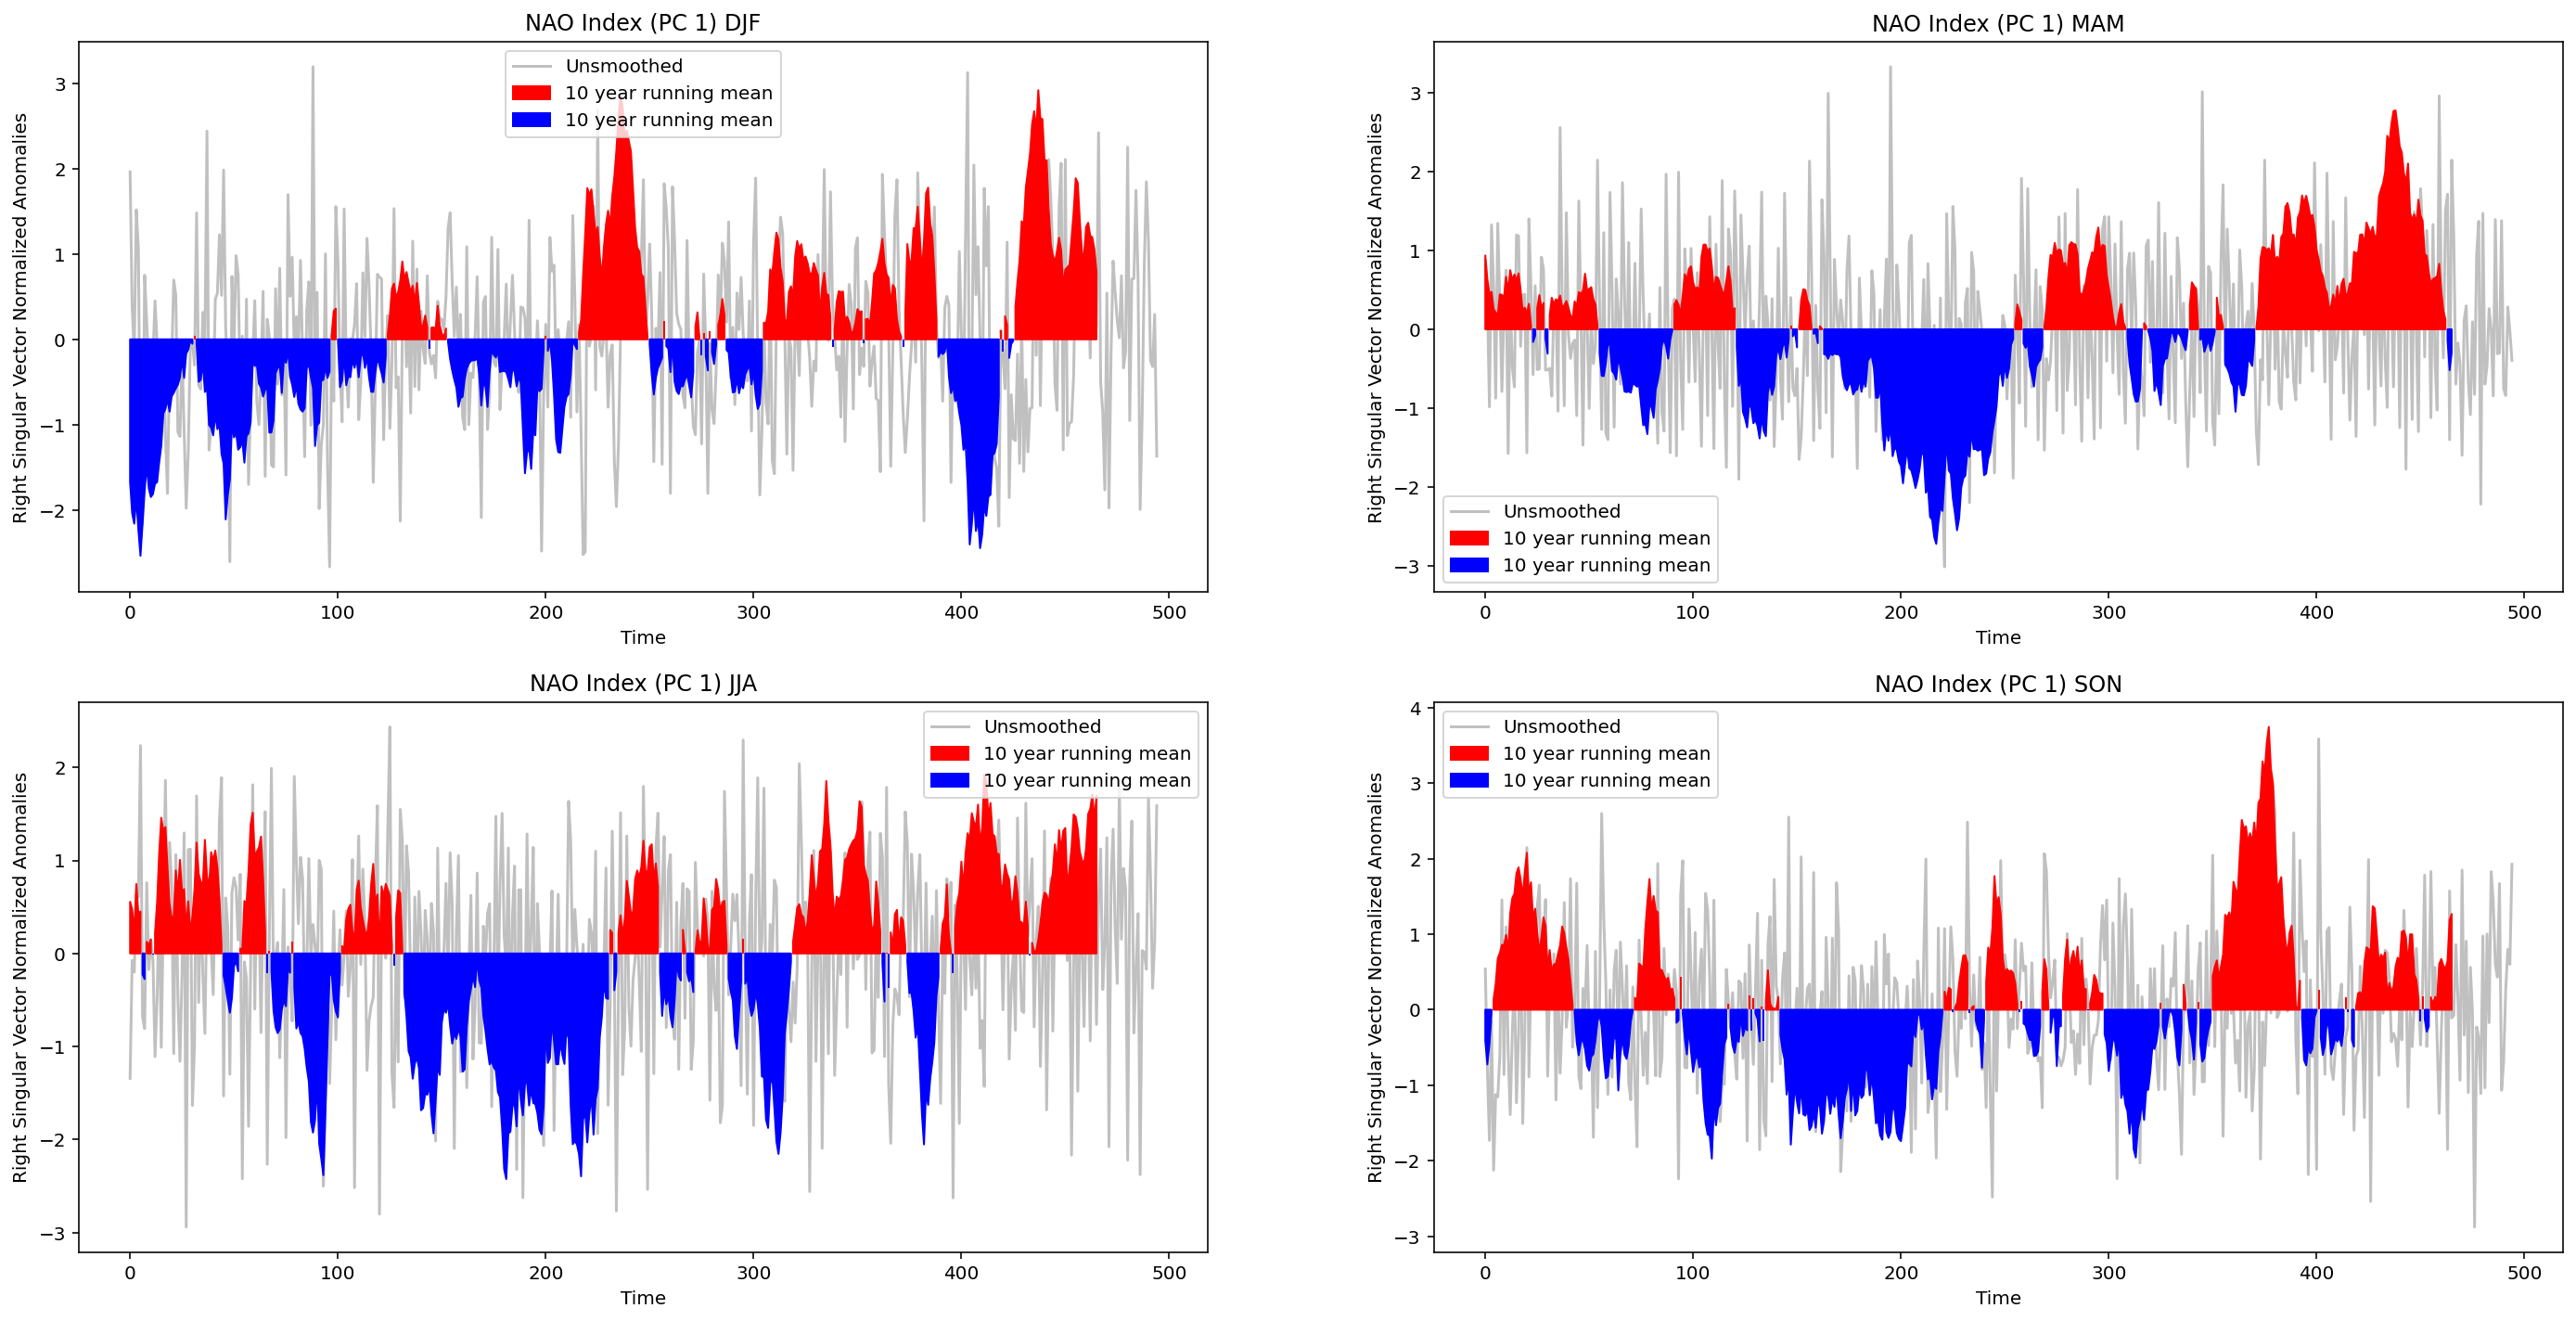

9
DJF
MAM
JJA
SON


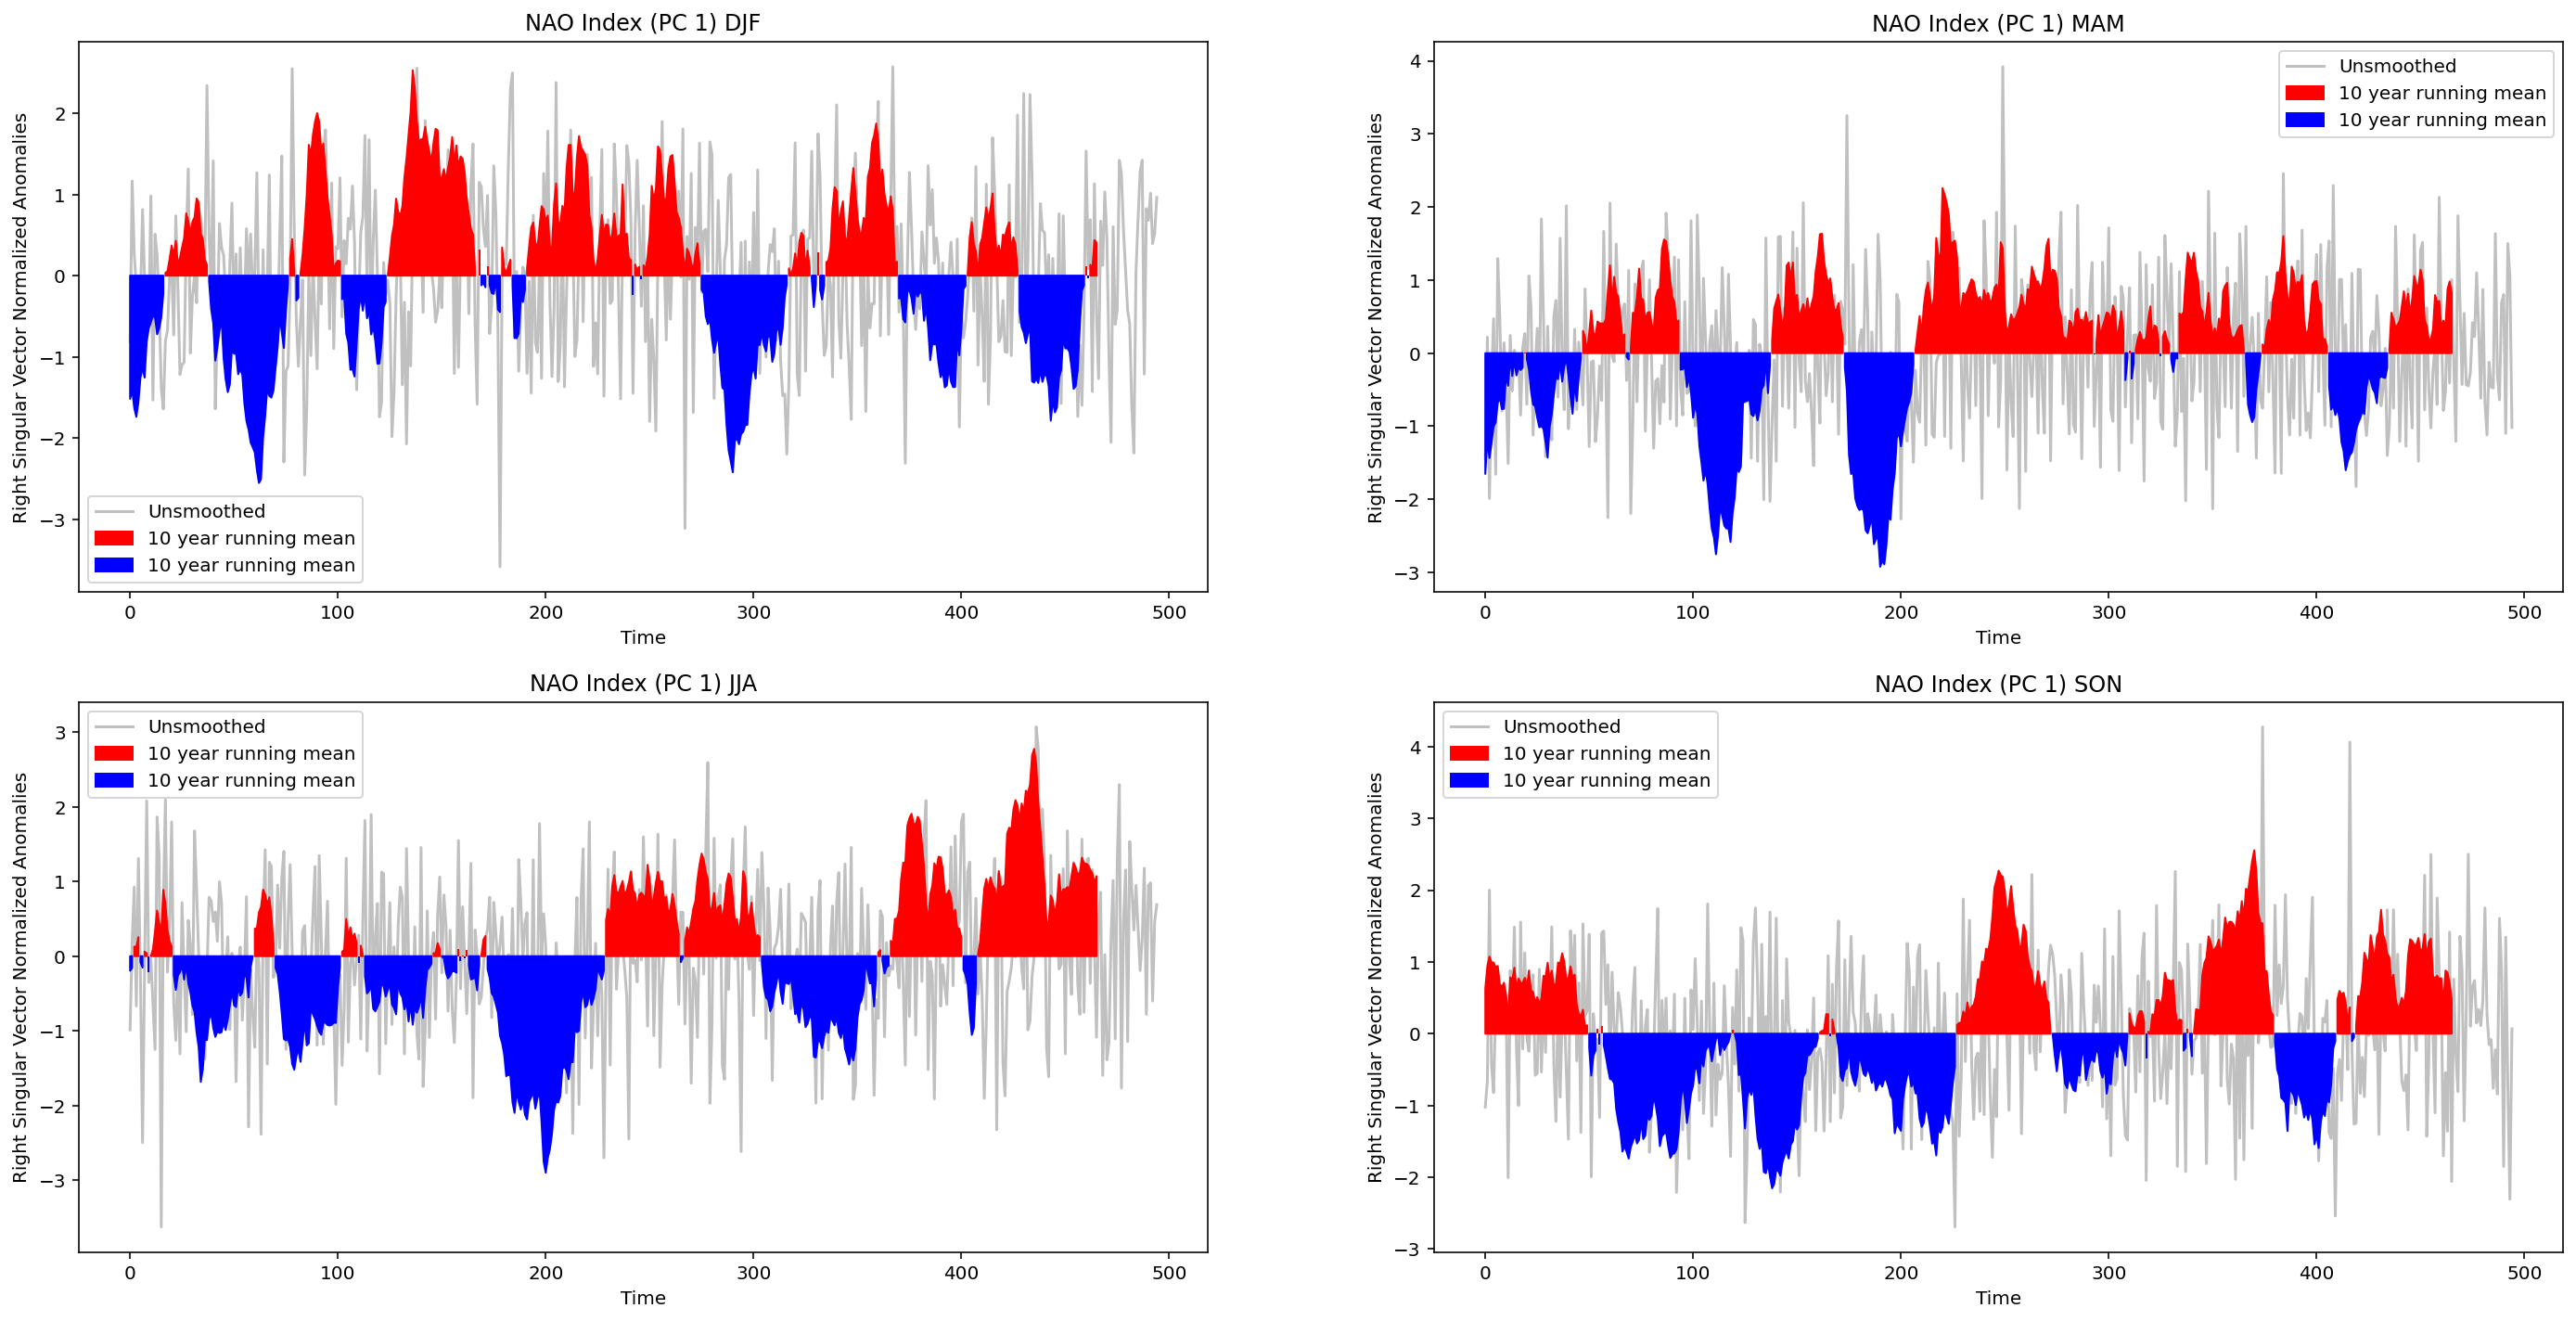

10
DJF
MAM
JJA
SON


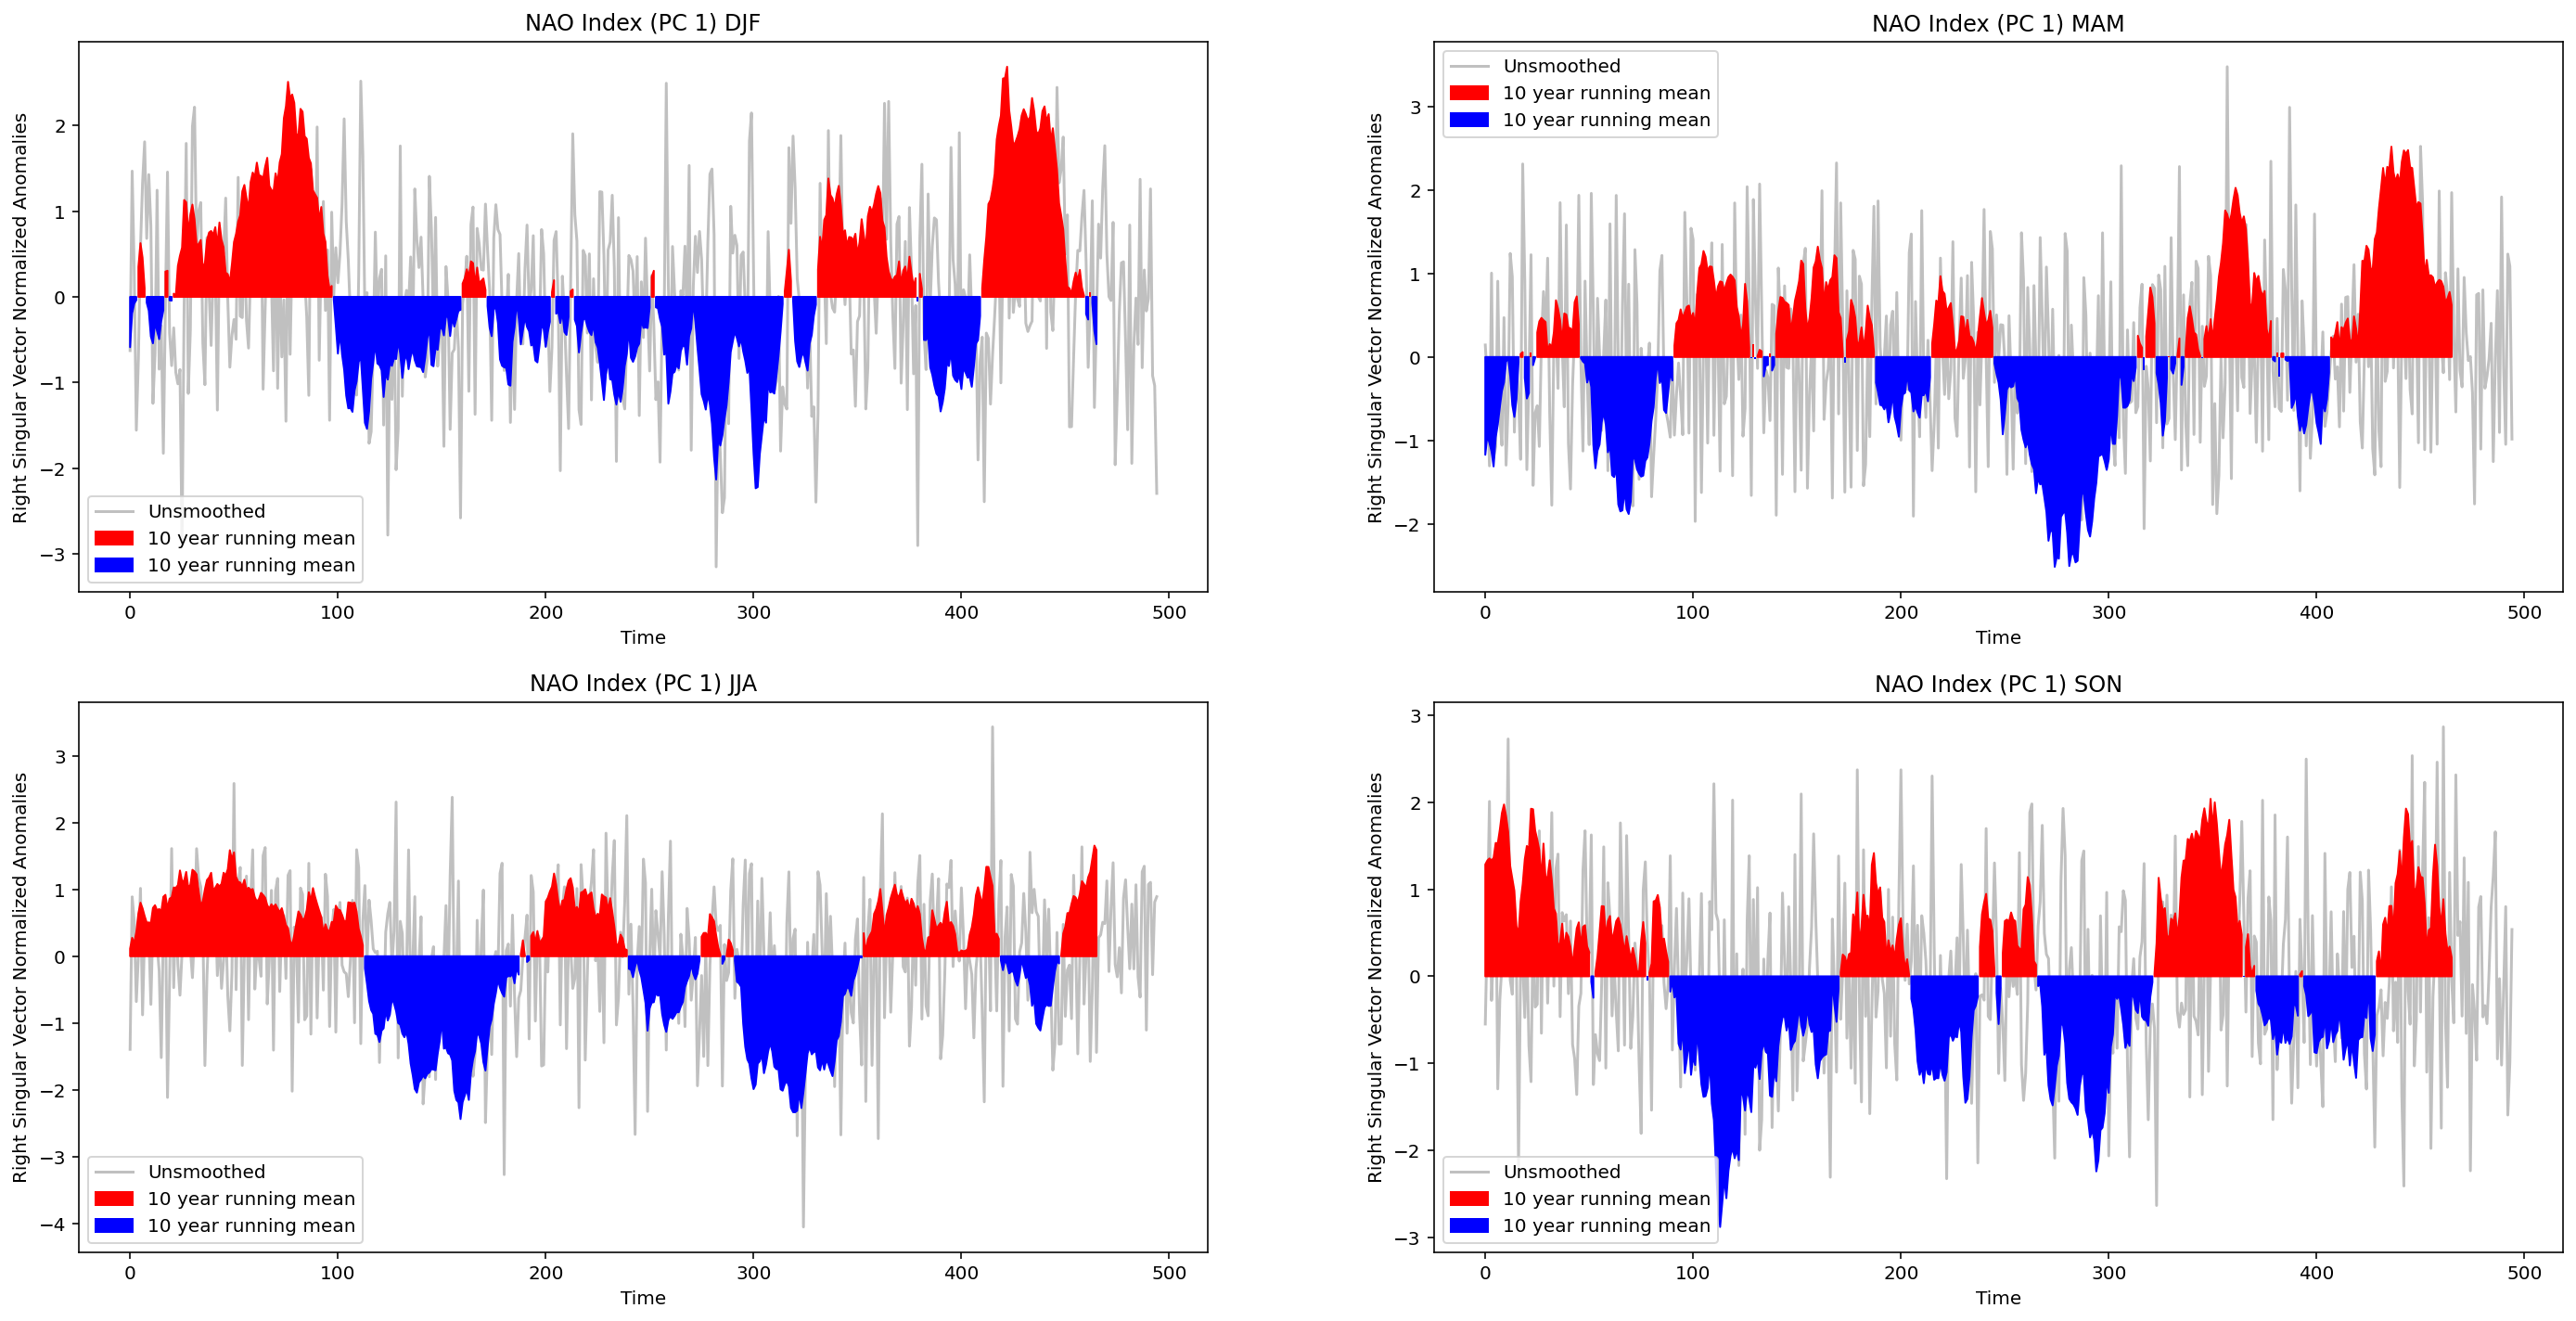

In [ ]:
for member in range(len(psl_ssp585.zstore.values)): 
  print(member)
  # Accessing the file, getting it to just the lats and lons I want:
  zstore = psl_ssp585.zstore.values[member]
  mapper = fsspec.get_mapper(zstore)
  ds = xr.open_zarr(mapper, consolidated=True, decode_times=True) # Make decode_times=True to convert dates to datetime objects?? The problem is, Colab doesn't seem to like my installation of nc-time-axis. I could try a Jupyter Binder, or keep Googling to try to solve this.
  psl = ds.psl.sel(lat=slice(20,80))
  psl = psl.where((ds.lon >= 270) | (ds.lon <= 40), drop=True)
  lat = ds.lat.sel(lat=slice(20,80))
  lon = ds.lon.where((ds.lon >= 270) | (ds.lon <= 40), drop=True) # Not sure exactly what drop means, but I think it doesn't matter


  # Useful stackexchange post: https://stackoverflow.com/questions/40272222/select-xarray-pandas-index-based-on-specific-months
  def is_djf(month):
    return (month>=12) | ((month>=1) & (month<=2))
  def is_mam(month):
    return (month>=3) & (month<=5)
  def is_jja(month):
    return (month>=6) & (month<=8)
  def is_son(month):
    return (month>=9) & (month<=11)
  psl_djf = psl.sel(time=is_djf(psl['time.month']))
  psl_mam = psl.sel(time=is_mam(psl['time.month']))
  psl_jja = psl.sel(time=is_jja(psl['time.month']))
  psl_son = psl.sel(time=is_son(psl['time.month']))


  psl_allseasons = {
      'DJF': psl_djf,
      'MAM': psl_mam,
      'JJA': psl_jja,
      'SON': psl_son
  }
  century_trends = {
      'DJF': {},
      'JJA': {},
      'MAM': {},
      'SON': {}
  }
  for key in psl_allseasons.keys():
    print(key)
    tlength = len(psl_allseasons[key].time) # The psl_WEIGHTED dictionary does not contain DataArray objects, so I can't just get the time from that.
    psl2d = np.reshape(psl_allseasons[key].values, (tlength, 6720)) # This is the only line in the for loop I changed when adding in the weighting
    psl2d = np.matrix.transpose(psl2d)
    Unow, snow, VTnow = LA.svd(psl2d, full_matrices=False)
    century_trends[key]['U'] = Unow
    century_trends[key]['s'] = snow
    century_trends[key]['VT'] = VTnow
  eigenpatterns = {}
  SEASONS = ['DJF', 'MAM', 'JJA', 'SON']
  # Moving average code from https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy
  def moving_average(x, w):
      return np.convolve(x, np.ones(w), 'valid') / w
  eigenpatterns['singVal 0']={
      'anomalies': {},
      'normalized': {},
      'smoothed': {}
  }
  for season in SEASONS:
    eigenpatterns['singVal 0']['anomalies'][season] = century_trends[season]['VT'][0]-np.mean(century_trends[season]['VT'][0])
    eigenpatterns['singVal 0']['normalized'][season] = eigenpatterns['singVal 0']['anomalies'][season]/np.std(century_trends[season]['VT'][0])
    nao_smoothed = moving_average(eigenpatterns['singVal 0']['anomalies'][season], 30) # Doing the moving average for 30 points because each season is 3 months per year - so this is a 10 year running mean
    eigenpatterns['singVal 0']['smoothed'][season] = nao_smoothed/np.std(nao_smoothed)

  #   axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal '+singVal[-1]]['normalized'][season], where=eigenpatterns['singVal '+singVal[-1]]['normalized'][season]>0, color='r')
  #   axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal '+singVal[-1]]['normalized'][season], where=eigenpatterns['singVal '+singVal[-1]]['normalized'][season]<0, color='b')
  #   if int(singVal[-1])==0:
  #     axlist[SEASONS.index(season)].set_title('NAO Index (PC 1) '+season)
  #   else:
  #     axlist[SEASONS.index(season)].set_title('SLP PC '+str(int(singVal[-1])+1)+' '+season)
  #   axlist[SEASONS.index(season)].set_ylabel('Right Singular Vector Normalized Anomalies')
  #   axlist[SEASONS.index(season)].set_xlabel('Time')
  #   # axlist[SEASONS.index(season)].set_xticks(np.arange(495), ([j for j in psl_allseasons[season].time]))
  # plt.show()
  fig, axs = plt.subplots(2, 2, figsize=[24, 12])
  axlist = axs.flatten()
  for season in SEASONS:
    # x = np.arange(0, 495)
    x = np.arange(0, len(nao_smoothed))
    axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal 0']['smoothed'][season], where=eigenpatterns['singVal 0']['smoothed'][season]>0, color='r', label='10 year running mean')
    axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal 0']['smoothed'][season], where=eigenpatterns['singVal 0']['smoothed'][season]<0, color='b', label='10 year running mean')
    axlist[SEASONS.index(season)].plot(eigenpatterns['singVal 0']['normalized'][season], 'silver', zorder=0, label='Unsmoothed')
    # plt.plot(x)
    axlist[SEASONS.index(season)].set_title('NAO Index (PC 1) '+season)
    axlist[SEASONS.index(season)].set_ylabel('Right Singular Vector Normalized Anomalies')
    axlist[SEASONS.index(season)].set_xlabel('Time')
    axlist[SEASONS.index(season)].legend()
  plt.show()